# Lab 6: Association Rule Mining

**Name:** Bishal Thapa  
**Course:** MSCS 634 - Advanced Big Data and Data Mining  
**Lab Assignment:** Association Rule Mining with Apriori and FP-Growth Algorithms


## Step 1: Data Preparation

Load the dataset and apply necessary data cleaning steps to ensure the data is ready for mining. 
Ensure that the dataset has item-level transaction records (e.g., product IDs or names) for compatibility with Apriori and FP-Growth algorithms.  
Create visualizations to explore the dataset and highlight important characteristics (e.g., Seaborn's barplot to show the most frequently occurring items in the dataset, Seaborn's heatmap to visualize item co-occurrence and highlight strong associations between items). 


In [148]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Import Apriori algorithm from mlxtend
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
import time

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [149]:
# Load the dataset
#dataset link from kaggle: https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows?resource=download
df = pd.read_csv('imdb_top_1000.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()


Dataset Shape: (1000, 16)

Column Names:
['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate', 'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross']

First few rows:


,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


In [150]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
print("\nDataset Info:")
df.info()


Missing Values:
Poster_Link        0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    1000 non-null   object 
 1   Series_Title   1000 non-null   object 
 2   Released_Year  1000 non-null   object 
 3   Certificate    899 non-null    object 
 4   Runtime        1000 non-null   object 
 5   Genre          1000 non-null   object 
 6   IMDB_Rating    1000 non-null   float64
 7   Overview       1000 non-null   object 
 8   Meta_score     843 non-null    float64
 9   Director       1000 non-n

### Data Cleaning and Preparation

For association rule mining, we need to transform the dataset into a transactional format. We'll use **genres** as items since movies can have multiple genres, making each movie a transaction containing its genres.


In [151]:
# Data cleaning: Handle missing values and prepare genre data
# Fill missing values in Genre column if any
df['Genre'] = df['Genre'].fillna('')

# Split genres (they are comma-separated) and create a list of genres for each movie
df['Genre_List'] = df['Genre'].str.split(', ')

# Remove any empty strings from genre lists
df['Genre_List'] = df['Genre_List'].apply(lambda x: [genre.strip() for genre in x if genre.strip() != ''])

# Display sample of cleaned data
print("Sample of movies with their genres:")
for idx, row in df[['Series_Title', 'Genre_List']].head(10).iterrows():
    print(f"{row['Series_Title']}: {row['Genre_List']}")


Sample of movies with their genres:
The Shawshank Redemption: ['Drama']
The Godfather: ['Crime', 'Drama']
The Dark Knight: ['Action', 'Crime', 'Drama']
The Godfather: Part II: ['Crime', 'Drama']
12 Angry Men: ['Crime', 'Drama']
The Lord of the Rings: The Return of the King: ['Action', 'Adventure', 'Drama']
Pulp Fiction: ['Crime', 'Drama']
Schindler's List: ['Biography', 'Drama', 'History']
Inception: ['Action', 'Adventure', 'Sci-Fi']
Fight Club: ['Drama']


In [152]:
# Create transactional dataset for association rule mining
# Each row represents a transaction (movie) with its items (genres)
transactions = df['Genre_List'].tolist()

# Remove any empty transactions
transactions = [t for t in transactions if len(t) > 0]

print(f"Total number of transactions: {len(transactions)}")
print(f"\nSample transactions:")
for i, trans in enumerate(transactions[:5]):
    print(f"Transaction {i+1}: {trans}")


Total number of transactions: 1000

Sample transactions:
Transaction 1: ['Drama']
Transaction 2: ['Crime', 'Drama']
Transaction 3: ['Action', 'Crime', 'Drama']
Transaction 4: ['Crime', 'Drama']
Transaction 5: ['Crime', 'Drama']


In [153]:
# Get all unique genres (items)
all_genres = []
for transaction in transactions:
    all_genres.extend(transaction)

unique_genres = list(set(all_genres))
print(f"Total number of unique genres (items): {len(unique_genres)}")
print(f"\nAll genres: {sorted(unique_genres)}")


Total number of unique genres (items): 21

All genres: ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']


### Most Frequently Occurring Items (Genres)

Displaying a barplot to show the most frequently occurring genres in the dataset.


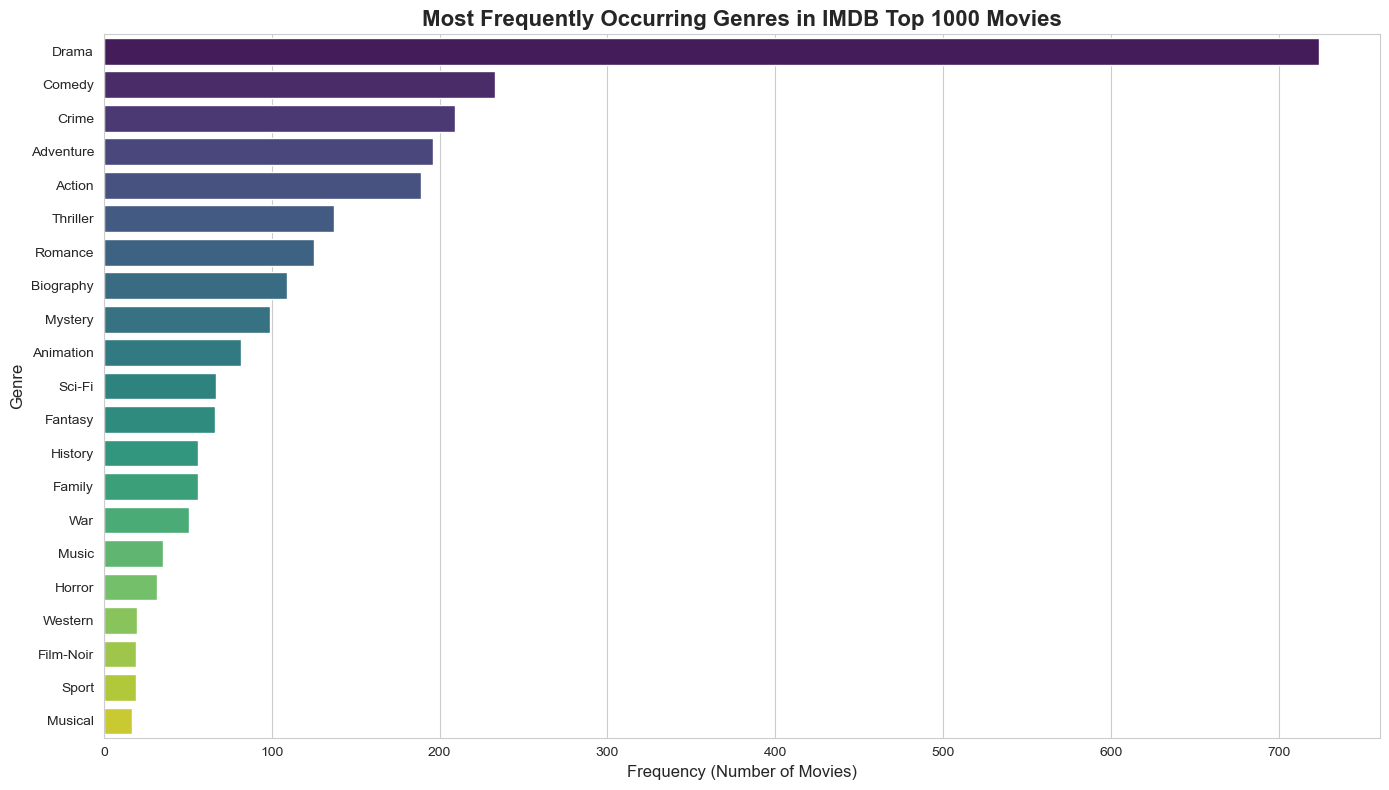

Top 10 Most Frequent Genres:
        Genre  Frequency
0       Drama        724
10     Comedy        233
1       Crime        209
3   Adventure        196
2      Action        189
11   Thriller        137
7     Romance        125
4   Biography        109
15    Mystery         99
12  Animation         82


In [154]:
# Count frequency of each genre
genre_counts = Counter(all_genres)

# Convert to DataFrame for easier plotting
genre_df = pd.DataFrame(list(genre_counts.items()), columns=['Genre', 'Frequency'])
genre_df = genre_df.sort_values('Frequency', ascending=False)

# Create barplot
plt.figure(figsize=(14, 8))
sns.barplot(data=genre_df, x='Frequency', y='Genre', palette='viridis')
plt.title('Most Frequently Occurring Genres in IMDB Top 1000 Movies', fontsize=16, fontweight='bold')
plt.xlabel('Frequency (Number of Movies)', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.tight_layout()
plt.show()

# Display top genres
print("Top 10 Most Frequent Genres:")
print(genre_df.head(10))


### Genre Co-occurrence Heatmap

Creating a heatmap to visualize item co-occurrence and highlight strong associations between genres.


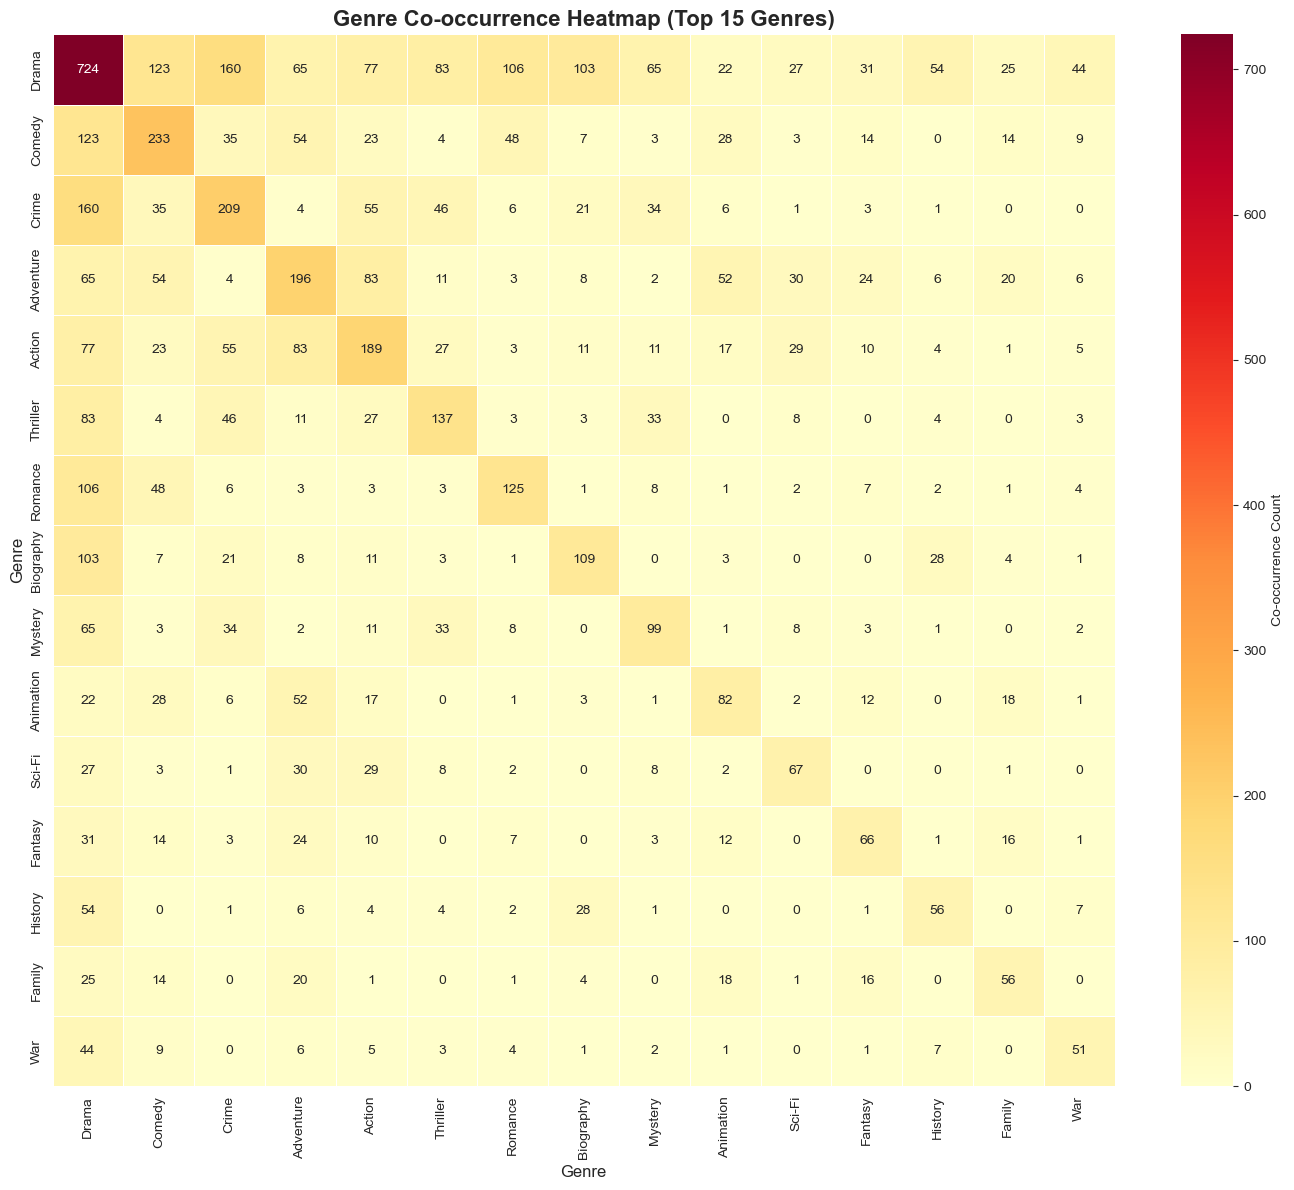


Co-occurrence Matrix (showing how often genres appear together):
           Drama  Comedy  Crime  Adventure  Action  Thriller  Romance  \
Drama        724     123    160         65      77        83      106   
Comedy       123     233     35         54      23         4       48   
Crime        160      35    209          4      55        46        6   
Adventure     65      54      4        196      83        11        3   
Action        77      23     55         83     189        27        3   
Thriller      83       4     46         11      27       137        3   
Romance      106      48      6          3       3         3      125   
Biography    103       7     21          8      11         3        1   
Mystery       65       3     34          2      11        33        8   
Animation     22      28      6         52      17         0        1   
Sci-Fi        27       3      1         30      29         8        2   
Fantasy       31      14      3         24      10        

In [155]:
# Create co-occurrence matrix for genres
# This will show how often genres appear together in the same movie

# Get top genres for better visualization (top 15 most frequent)
top_genres = genre_df.head(15)['Genre'].tolist()

# Initialize co-occurrence matrix
cooccurrence_matrix = pd.DataFrame(0, index=top_genres, columns=top_genres)

# Count co-occurrences
for transaction in transactions:
    # Get genres in this transaction that are in top_genres
    genres_in_trans = [g for g in transaction if g in top_genres]
    
    # Update co-occurrence matrix
    for i, genre1 in enumerate(genres_in_trans):
        for genre2 in genres_in_trans[i:]:
            if genre1 != genre2:
                cooccurrence_matrix.loc[genre1, genre2] += 1
                cooccurrence_matrix.loc[genre2, genre1] += 1
            else:
                # For same genre, count it once (diagonal)
                cooccurrence_matrix.loc[genre1, genre1] += 1

# Create heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(cooccurrence_matrix, annot=True, fmt='d', cmap='YlOrRd', 
            cbar_kws={'label': 'Co-occurrence Count'}, linewidths=0.5)
plt.title('Genre Co-occurrence Heatmap (Top 15 Genres)', fontsize=16, fontweight='bold')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.tight_layout()
plt.show()

print("\nCo-occurrence Matrix (showing how often genres appear together):")
print(cooccurrence_matrix)


Transaction Statistics:
Total number of transactions: 1000
Average number of genres per movie: 2.54
Minimum genres in a movie: 1
Maximum genres in a movie: 3
Median genres per movie: 3.00


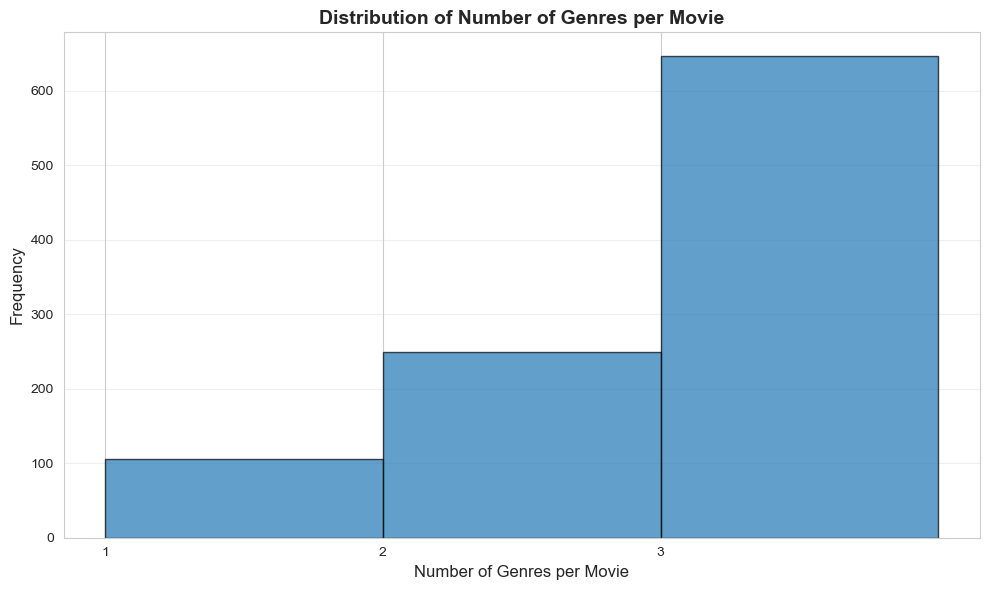

In [156]:
# Calculate statistics about transactions
transaction_lengths = [len(t) for t in transactions]

print("Transaction Statistics:")
print(f"Total number of transactions: {len(transactions)}")
print(f"Average number of genres per movie: {np.mean(transaction_lengths):.2f}")
print(f"Minimum genres in a movie: {min(transaction_lengths)}")
print(f"Maximum genres in a movie: {max(transaction_lengths)}")
print(f"Median genres per movie: {np.median(transaction_lengths):.2f}")

# Distribution of transaction lengths
plt.figure(figsize=(10, 6))
plt.hist(transaction_lengths, bins=range(1, max(transaction_lengths)+2), edgecolor='black', alpha=0.7)
plt.xlabel('Number of Genres per Movie', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Number of Genres per Movie', fontsize=14, fontweight='bold')
plt.xticks(range(1, max(transaction_lengths)+1))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## Step 2: Frequent Itemset Mining Using Apriori

In this step, we will:
1. Implement the Apriori algorithm to identify frequent itemsets
2. Set appropriate support thresholds based on dataset characteristics
3. Display frequent itemsets with their support values
4. Create visualizations to present insights from discovered itemsets


### Preparing Data for Apriori Algorithm

The Apriori algorithm requires data in a one-hot encoded format where each column represents an item and each row represents a transaction.


In [157]:
# Transform transactions into a one-hot encoded DataFrame
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print("Shape of encoded DataFrame:", df_encoded.shape)
print("\nFirst few rows of encoded data:")
print(df_encoded.head())
print("\nColumn names (items):")
print(df_encoded.columns.tolist())


Shape of encoded DataFrame: (1000, 21)

First few rows of encoded data:
   Action  Adventure  Animation  Biography  Comedy  Crime  Drama  Family  \
0   False      False      False      False   False  False   True   False   
1   False      False      False      False   False   True   True   False   
2    True      False      False      False   False   True   True   False   
3   False      False      False      False   False   True   True   False   
4   False      False      False      False   False   True   True   False   

   Fantasy  Film-Noir  ...  Horror  Music  Musical  Mystery  Romance  Sci-Fi  \
0    False      False  ...   False  False    False    False    False   False   
1    False      False  ...   False  False    False    False    False   False   
2    False      False  ...   False  False    False    False    False   False   
3    False      False  ...   False  False    False    False    False   False   
4    False      False  ...   False  False    False    False    False   

### Setting Support Threshold

Support threshold determines the minimum frequency for an itemset to be considered frequent. 
For a dataset with 1000 transactions, we'll experiment with different support thresholds to find meaningful patterns.


In [158]:
# Calculate support for different threshold values to understand the data
# Support = (Number of transactions containing itemset) / (Total number of transactions)

# Let's analyze what support thresholds would be appropriate
print("Analyzing support thresholds:")
print(f"Total transactions: {len(transactions)}")
print("\nSupport threshold analysis:")
print("Support 0.01 (1%) = at least 10 transactions")
print("Support 0.05 (5%) = at least 50 transactions")
print("Support 0.10 (10%) = at least 100 transactions")
print("Support 0.15 (15%) = at least 150 transactions")
print("Support 0.20 (20%) = at least 200 transactions")

# We'll start with a moderate support threshold
# For this dataset, let's use 0.05 (5%) as it will capture meaningful patterns
# while filtering out very rare combinations
min_support = 0.05
print(f"\nUsing minimum support threshold: {min_support} ({min_support*100}%)")


Analyzing support thresholds:
Total transactions: 1000

Support threshold analysis:
Support 0.01 (1%) = at least 10 transactions
Support 0.05 (5%) = at least 50 transactions
Support 0.10 (10%) = at least 100 transactions
Support 0.15 (15%) = at least 150 transactions
Support 0.20 (20%) = at least 200 transactions

Using minimum support threshold: 0.05 (5.0%)


### Running Apriori Algorithm

Now we'll apply the Apriori algorithm to find frequent itemsets.


In [159]:
# Apply Apriori algorithm
frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)

# Sort by support in descending order
frequent_itemsets = frequent_itemsets.sort_values('support', ascending=False)

print(f"Total number of frequent itemsets found: {len(frequent_itemsets)}")
print(f"\nFrequent itemsets with support >= {min_support}:")
print(frequent_itemsets.head(20))


Total number of frequent itemsets found: 28

Frequent itemsets with support >= 0.05:
    support             itemsets
6     0.724              (Drama)
4     0.233             (Comedy)
5     0.209              (Crime)
1     0.196          (Adventure)
0     0.189             (Action)
23    0.160       (Drama, Crime)
13    0.137           (Thriller)
11    0.125            (Romance)
22    0.123      (Drama, Comedy)
3     0.109          (Biography)
26    0.106     (Romance, Drama)
21    0.103   (Drama, Biography)
10    0.099            (Mystery)
15    0.083  (Action, Adventure)
27    0.083    (Drama, Thriller)
2     0.082          (Animation)
17    0.077      (Drama, Action)
12    0.067             (Sci-Fi)
8     0.066            (Fantasy)
20    0.065   (Drama, Adventure)


In [160]:
# Display all frequent itemsets grouped by itemset size
print("Frequent Itemsets by Size:\n")

for itemset_size in range(1, int(frequent_itemsets['itemsets'].apply(len).max()) + 1):
    itemsets_of_size = frequent_itemsets[frequent_itemsets['itemsets'].apply(len) == itemset_size]
    if len(itemsets_of_size) > 0:
        print(f"\n{itemset_size}-Itemsets ({len(itemsets_of_size)} found):")
        print("-" * 60)
        for idx, row in itemsets_of_size.iterrows():
            itemset_str = ', '.join(list(row['itemsets']))
            print(f"  {itemset_str}: Support = {row['support']:.4f} ({row['support']*100:.2f}%)")


Frequent Itemsets by Size:


1-Itemsets (15 found):
------------------------------------------------------------
  Drama: Support = 0.7240 (72.40%)
  Comedy: Support = 0.2330 (23.30%)
  Crime: Support = 0.2090 (20.90%)
  Adventure: Support = 0.1960 (19.60%)
  Action: Support = 0.1890 (18.90%)
  Thriller: Support = 0.1370 (13.70%)
  Romance: Support = 0.1250 (12.50%)
  Biography: Support = 0.1090 (10.90%)
  Mystery: Support = 0.0990 (9.90%)
  Animation: Support = 0.0820 (8.20%)
  Sci-Fi: Support = 0.0670 (6.70%)
  Fantasy: Support = 0.0660 (6.60%)
  History: Support = 0.0560 (5.60%)
  Family: Support = 0.0560 (5.60%)
  War: Support = 0.0510 (5.10%)

2-Itemsets (13 found):
------------------------------------------------------------
  Drama, Crime: Support = 0.1600 (16.00%)
  Drama, Comedy: Support = 0.1230 (12.30%)
  Romance, Drama: Support = 0.1060 (10.60%)
  Drama, Biography: Support = 0.1030 (10.30%)
  Action, Adventure: Support = 0.0830 (8.30%)
  Drama, Thriller: Support = 0.0830 (8

### Visualization: Top N Frequent Itemsets

Create a barplot to visualize the top N frequent itemsets with their support values.


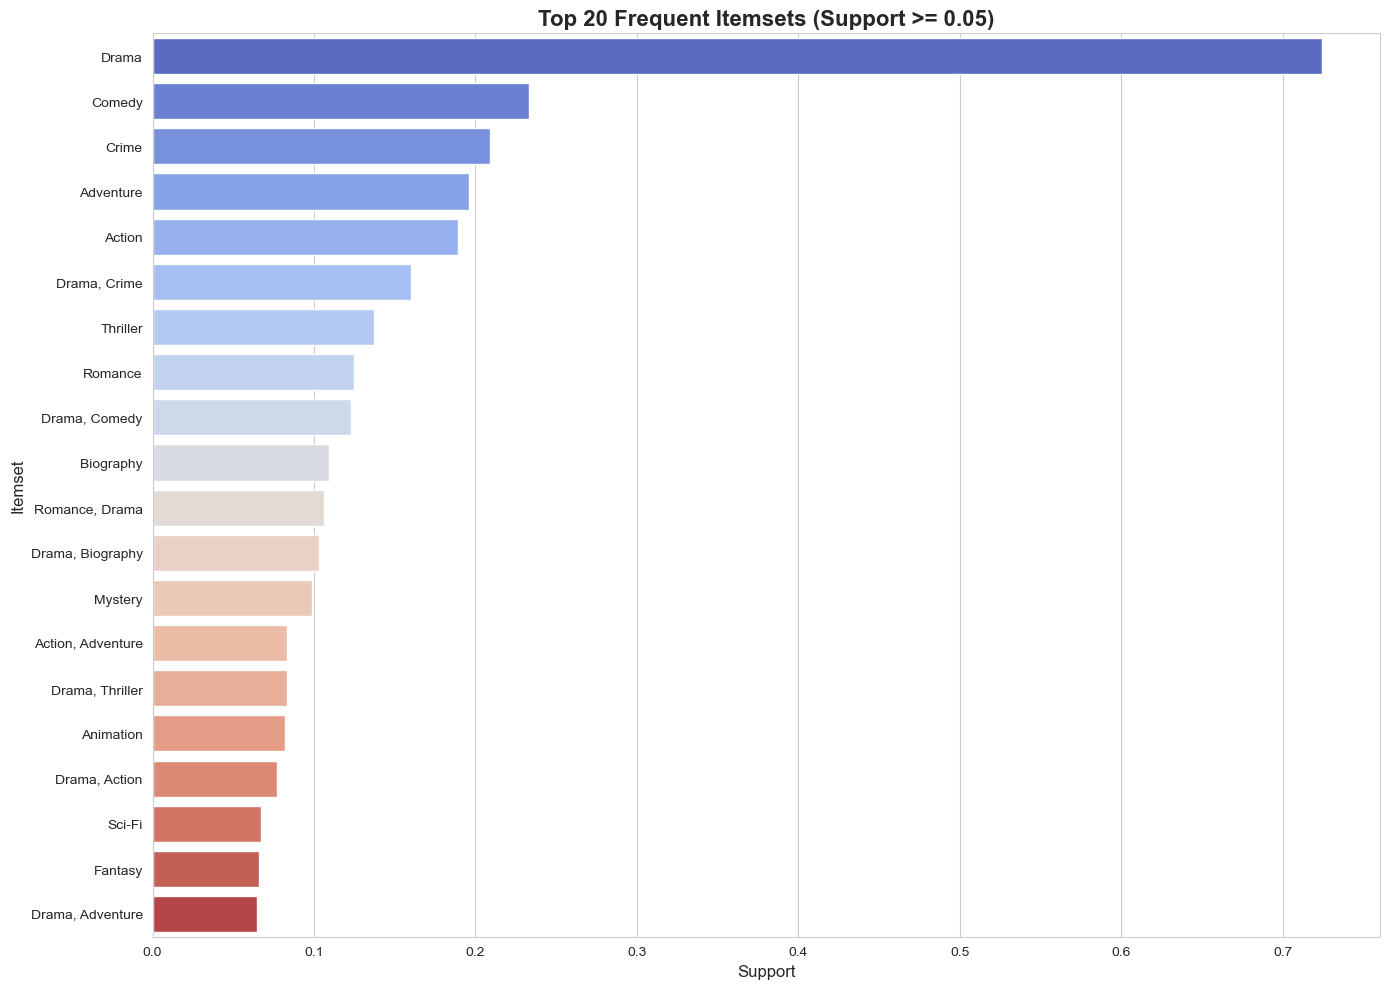


Top 20 Frequent Itemsets:
      itemset_str  support
            Drama    0.724
           Comedy    0.233
            Crime    0.209
        Adventure    0.196
           Action    0.189
     Drama, Crime    0.160
         Thriller    0.137
          Romance    0.125
    Drama, Comedy    0.123
        Biography    0.109
   Romance, Drama    0.106
 Drama, Biography    0.103
          Mystery    0.099
Action, Adventure    0.083
  Drama, Thriller    0.083
        Animation    0.082
    Drama, Action    0.077
           Sci-Fi    0.067
          Fantasy    0.066
 Drama, Adventure    0.065


In [161]:
# Prepare data for visualization
# Convert itemsets to strings for better display
frequent_itemsets['itemset_str'] = frequent_itemsets['itemsets'].apply(
    lambda x: ', '.join(list(x))
)

# Select top N itemsets (let's use top 20)
top_n = 20
top_itemsets = frequent_itemsets.head(top_n).copy()

# Create barplot
plt.figure(figsize=(14, 10))
sns.barplot(data=top_itemsets, x='support', y='itemset_str', palette='coolwarm')
plt.title(f'Top {top_n} Frequent Itemsets (Support >= {min_support})', 
          fontsize=16, fontweight='bold')
plt.xlabel('Support', fontsize=12)
plt.ylabel('Itemset', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nTop {top_n} Frequent Itemsets:")
print(top_itemsets[['itemset_str', 'support']].to_string(index=False))


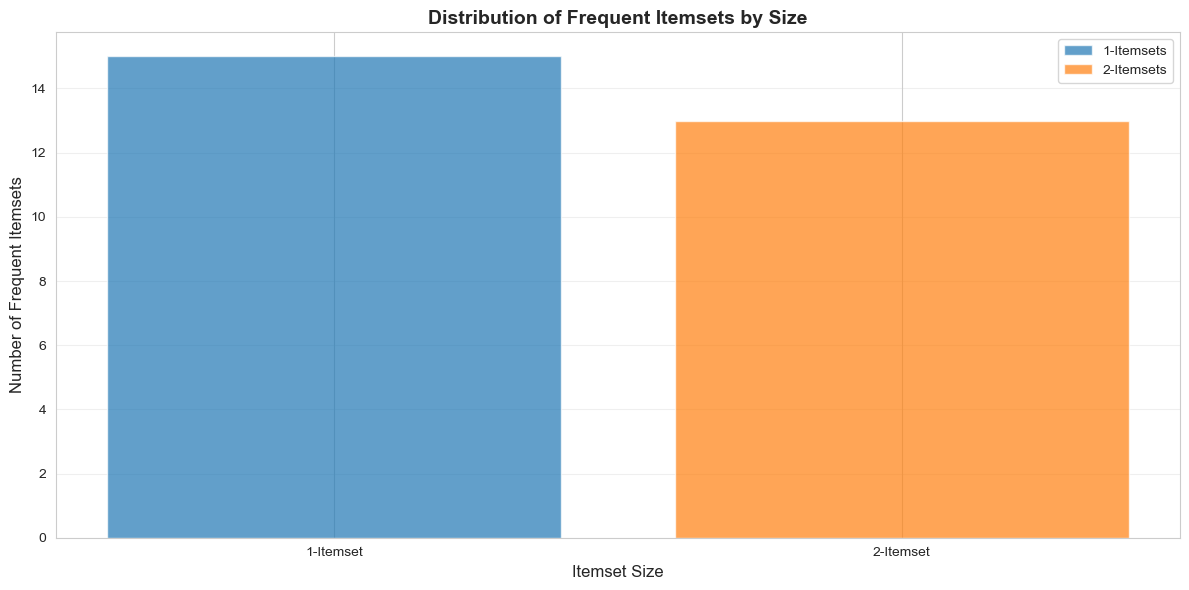


Summary by Itemset Size:
             support                      
               count    mean    min    max
itemset_size                              
1                 15  0.1599  0.051  0.724
2                 13  0.0831  0.052  0.160


In [162]:
# Additional visualization: Support distribution by itemset size
itemset_sizes = frequent_itemsets['itemsets'].apply(len)
frequent_itemsets['itemset_size'] = itemset_sizes

# Create a grouped bar chart showing support by itemset size
plt.figure(figsize=(12, 6))
for size in sorted(itemset_sizes.unique()):
    size_data = frequent_itemsets[frequent_itemsets['itemset_size'] == size]
    plt.bar([f'{size}-Itemset'], [len(size_data)], alpha=0.7, label=f'{size}-Itemsets')

plt.xlabel('Itemset Size', fontsize=12)
plt.ylabel('Number of Frequent Itemsets', fontsize=12)
plt.title('Distribution of Frequent Itemsets by Size', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nSummary by Itemset Size:")
print(frequent_itemsets.groupby('itemset_size').agg({
    'support': ['count', 'mean', 'min', 'max']
}).round(4))


Experimenting with different support thresholds:

----------------------------------------------------------------------
 Support  Count  Max Size
    0.01     83         3
    0.05     28         2
    0.10     12         2
    0.15      6         2
    0.20      3         1


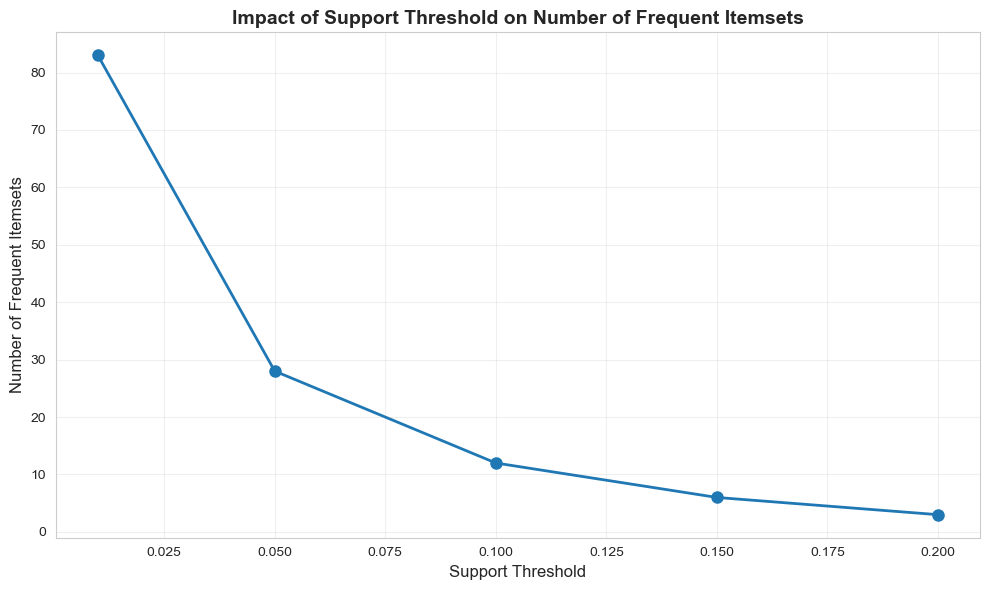

In [163]:
# Experiment with different support thresholds to see the impact
print("Experimenting with different support thresholds:\n")
print("-" * 70)

support_thresholds = [0.01, 0.05, 0.10, 0.15, 0.20]
results = []

for threshold in support_thresholds:
    itemsets = apriori(df_encoded, min_support=threshold, use_colnames=True)
    max_size = itemsets['itemsets'].apply(len).max() if len(itemsets) > 0 else 0
    results.append({
        'Support': threshold,
        'Count': len(itemsets),
        'Max Size': max_size
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# Visualize the impact of different support thresholds
plt.figure(figsize=(10, 6))
plt.plot(results_df['Support'], results_df['Count'], marker='o', linewidth=2, markersize=8)
plt.xlabel('Support Threshold', fontsize=12)
plt.ylabel('Number of Frequent Itemsets', fontsize=12)
plt.title('Impact of Support Threshold on Number of Frequent Itemsets', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Summary of Frequent Itemsets

The Apriori algorithm has identified the frequent itemsets in the dataset. The number of frequent itemsets depends on the chosen minimum support, and these itemsets include both single genres and combinations of multiple genres. Their support values range from the minimum threshold to higher values, indicating how common each pattern is. Overall, these frequent itemsets reveal which genres often appear together in the IMDB Top 1000 movies, providing insights into popular genre combinations and viewer preferences.

## Step 3: Frequent Itemset Mining Using FP-Growth

Use the FP-Growth algorithm to identify frequent itemsets in the dataset.   
Apply the same support threshold as used in the Apriori algorithm.    
Compare the efficiency and output of the FP-Growth algorithm with Apriori.     
Use visualizations to present insights from the discovered itemsets (e.g., a Seaborn barplot to visualize the top N frequent itemsets with their support values). 
 




### Running FP-Growth Algorithm

FP-Growth (Frequent Pattern Growth) is an efficient algorithm that uses a tree structure (FP-tree) to mine frequent itemsets without candidate generation, making it typically faster than Apriori for large datasets.


In [164]:
# Use the same support threshold as Apriori
print(f"Using the same minimum support threshold: {min_support} ({min_support*100}%)")
print(f"Total transactions: {len(transactions)}")
print(f"Total unique items: {len(df_encoded.columns)}")

# Run FP-Growth algorithm and measure execution time
print("\nRunning FP-Growth algorithm...")
start_time = time.time()
frequent_itemsets_fp = fpgrowth(df_encoded, min_support=min_support, use_colnames=True)
fp_time = time.time() - start_time

# Sort by support in descending order
frequent_itemsets_fp = frequent_itemsets_fp.sort_values('support', ascending=False)

print(f"\nFP-Growth execution time: {fp_time:.4f} seconds")
print(f"Total number of frequent itemsets found: {len(frequent_itemsets_fp)}")
print(f"\nFrequent itemsets with support >= {min_support}:")
print(frequent_itemsets_fp.head(20))


Using the same minimum support threshold: 0.05 (5.0%)
Total transactions: 1000
Total unique items: 21

Running FP-Growth algorithm...

FP-Growth execution time: 0.0440 seconds
Total number of frequent itemsets found: 28

Frequent itemsets with support >= 0.05:
    support             itemsets
0     0.724              (Drama)
9     0.233             (Comedy)
1     0.209              (Crime)
3     0.196          (Adventure)
2     0.189             (Action)
15    0.160       (Drama, Crime)
10    0.137           (Thriller)
7     0.125            (Romance)
24    0.123      (Drama, Comedy)
4     0.109          (Biography)
23    0.106     (Romance, Drama)
21    0.103   (Drama, Biography)
14    0.099            (Mystery)
18    0.083  (Action, Adventure)
25    0.083    (Drama, Thriller)
11    0.082          (Animation)
16    0.077      (Drama, Action)
6     0.067             (Sci-Fi)
8     0.066            (Fantasy)
19    0.065   (Drama, Adventure)


In [165]:
# Display all frequent itemsets grouped by itemset size
print("FP-Growth Frequent Itemsets by Size:\n")
print("=" * 60)

for itemset_size in range(1, int(frequent_itemsets_fp['itemsets'].apply(len).max()) + 1):
    itemsets_of_size = frequent_itemsets_fp[frequent_itemsets_fp['itemsets'].apply(len) == itemset_size]
    if len(itemsets_of_size) > 0:
        print(f"\n{itemset_size}-Itemsets ({len(itemsets_of_size)} found):")
        print("-" * 60)
        for idx, row in itemsets_of_size.iterrows():
            itemset_str = ', '.join(list(row['itemsets']))
            print(f"  {itemset_str}: Support = {row['support']:.4f} ({row['support']*100:.2f}%)")


FP-Growth Frequent Itemsets by Size:


1-Itemsets (15 found):
------------------------------------------------------------
  Drama: Support = 0.7240 (72.40%)
  Comedy: Support = 0.2330 (23.30%)
  Crime: Support = 0.2090 (20.90%)
  Adventure: Support = 0.1960 (19.60%)
  Action: Support = 0.1890 (18.90%)
  Thriller: Support = 0.1370 (13.70%)
  Romance: Support = 0.1250 (12.50%)
  Biography: Support = 0.1090 (10.90%)
  Mystery: Support = 0.0990 (9.90%)
  Animation: Support = 0.0820 (8.20%)
  Sci-Fi: Support = 0.0670 (6.70%)
  Fantasy: Support = 0.0660 (6.60%)
  Family: Support = 0.0560 (5.60%)
  History: Support = 0.0560 (5.60%)
  War: Support = 0.0510 (5.10%)

2-Itemsets (13 found):
------------------------------------------------------------
  Drama, Crime: Support = 0.1600 (16.00%)
  Drama, Comedy: Support = 0.1230 (12.30%)
  Romance, Drama: Support = 0.1060 (10.60%)
  Drama, Biography: Support = 0.1030 (10.30%)
  Action, Adventure: Support = 0.0830 (8.30%)
  Drama, Thriller: Support =

### Comparison: Apriori vs FP-Growth

Let's compare the efficiency and output of both algorithms.


In [166]:
# Re-run Apriori to measure execution time for fair comparison
print("Re-running Apriori algorithm for timing comparison...")
start_time = time.time()
frequent_itemsets_apriori = apriori(df_encoded, min_support=min_support, use_colnames=True)
apriori_time = time.time() - start_time
frequent_itemsets_apriori = frequent_itemsets_apriori.sort_values('support', ascending=False)

print("ALGORITHM COMPARISON")
print("-" * 70)
print(f"\nSupport Threshold: {min_support} ({min_support*100}%)")
print(f"\n{'Metric':<30} {'Apriori':<20} {'FP-Growth':<20}")
print("-" * 70)
print(f"{'Execution Time (seconds)':<30} {apriori_time:<20.4f} {fp_time:<20.4f}")
print(f"{'Number of Itemsets Found':<30} {len(frequent_itemsets_apriori):<20} {len(frequent_itemsets_fp):<20}")
print(f"{'Speedup Factor':<30} {'1.00x':<20} {f'{apriori_time/fp_time:.2f}x':<20}")

# Check if results are identical
apriori_sets = set(frozenset(row['itemsets']) for _, row in frequent_itemsets_apriori.iterrows())
fp_sets = set(frozenset(row['itemsets']) for _, row in frequent_itemsets_fp.iterrows())

if apriori_sets == fp_sets:
    print(f"\n✓ Results are IDENTICAL: Both algorithms found the same itemsets")
else:
    print(f"\n⚠ Results DIFFER:")
    only_apriori = apriori_sets - fp_sets
    only_fp = fp_sets - apriori_sets
    if only_apriori:
        print(f"  Itemsets only in Apriori: {len(only_apriori)}")
    if only_fp:
        print(f"  Itemsets only in FP-Growth: {len(only_fp)}")


Re-running Apriori algorithm for timing comparison...
ALGORITHM COMPARISON
----------------------------------------------------------------------

Support Threshold: 0.05 (5.0%)

Metric                         Apriori              FP-Growth           
----------------------------------------------------------------------
Execution Time (seconds)       0.0054               0.0440              
Number of Itemsets Found       28                   28                  
Speedup Factor                 1.00x                0.12x               

✓ Results are IDENTICAL: Both algorithms found the same itemsets


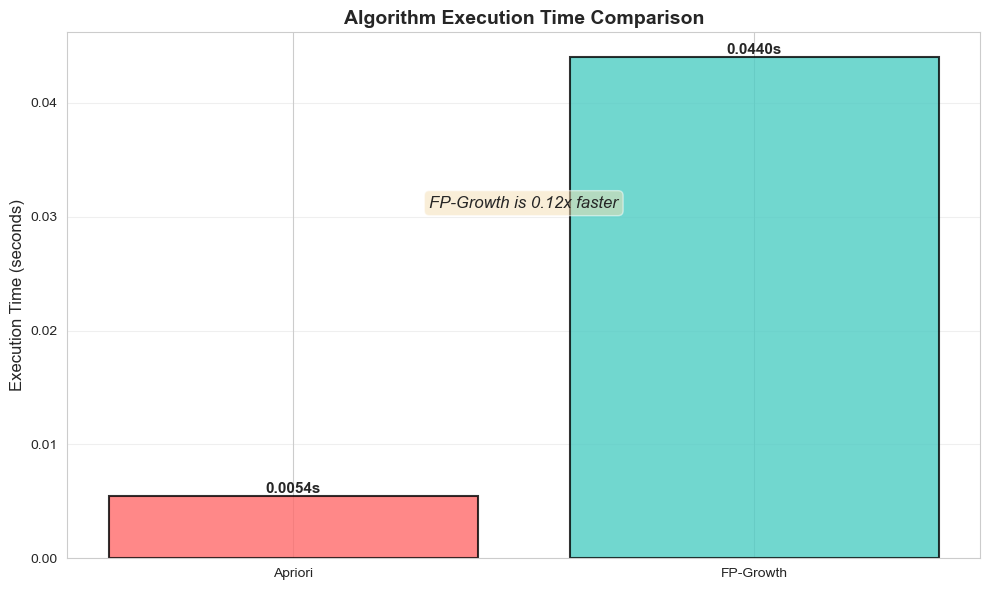

In [167]:
# Visualize execution time comparison
algorithms = ['Apriori', 'FP-Growth']
execution_times = [apriori_time, fp_time]
colors = ['#FF6B6B', '#4ECDC4']

plt.figure(figsize=(10, 6))
bars = plt.bar(algorithms, execution_times, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
plt.ylabel('Execution Time (seconds)', fontsize=12)
plt.title('Algorithm Execution Time Comparison', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, time_val in zip(bars, execution_times):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{time_val:.4f}s',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add speedup annotation
speedup = apriori_time / fp_time
plt.text(0.5, max(execution_times) * 0.7, 
         f'FP-Growth is {speedup:.2f}x faster',
         ha='center', fontsize=12, style='italic',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


Itemset Count Comparison by Size:
          Apriori  FP-Growth
itemsets                    
1              15         15
2              13         13


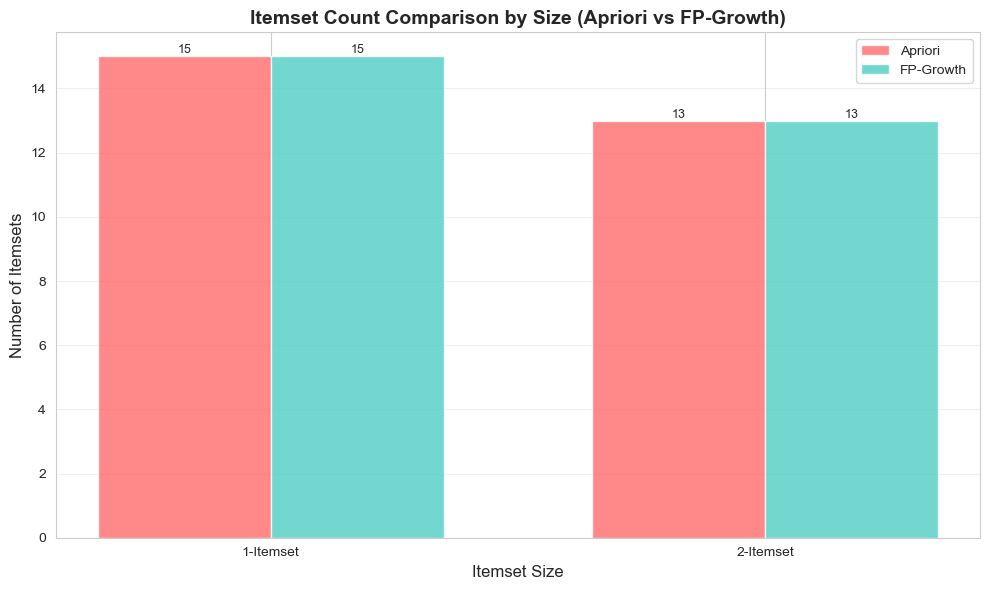

In [168]:
# Compare itemset counts by size
apriori_sizes = frequent_itemsets_apriori['itemsets'].apply(len).value_counts().sort_index()
fp_sizes = frequent_itemsets_fp['itemsets'].apply(len).value_counts().sort_index()

comparison_df = pd.DataFrame({
    'Apriori': apriori_sizes,
    'FP-Growth': fp_sizes
}).fillna(0).astype(int)

print("Itemset Count Comparison by Size:")
print("=" * 50)
print(comparison_df)

# Visualize itemset count comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_df.index))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Apriori'], width, label='Apriori', color='#FF6B6B', alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_df['FP-Growth'], width, label='FP-Growth', color='#4ECDC4', alpha=0.8)

ax.set_xlabel('Itemset Size', fontsize=12)
ax.set_ylabel('Number of Itemsets', fontsize=12)
ax.set_title('Itemset Count Comparison by Size (Apriori vs FP-Growth)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'{int(i)}-Itemset' for i in comparison_df.index])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}',
                   ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


### Visualization: Top N Frequent Itemsets (FP-Growth)

Create a barplot to visualize the top N frequent itemsets discovered by FP-Growth with their support values.


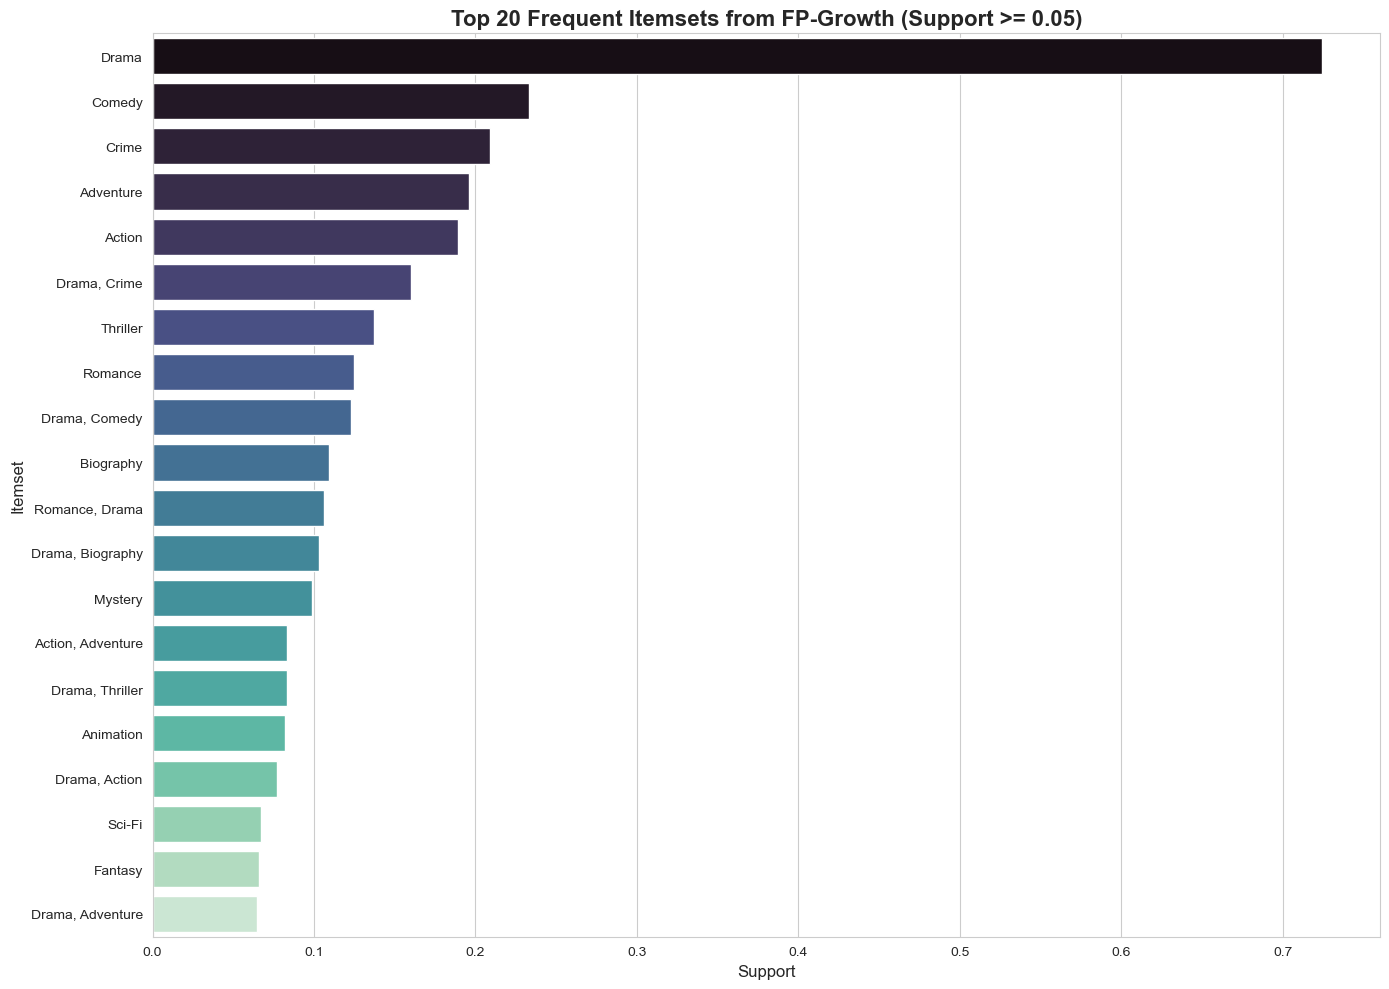


Top 20 Frequent Itemsets (FP-Growth):
      itemset_str  support
            Drama    0.724
           Comedy    0.233
            Crime    0.209
        Adventure    0.196
           Action    0.189
     Drama, Crime    0.160
         Thriller    0.137
          Romance    0.125
    Drama, Comedy    0.123
        Biography    0.109
   Romance, Drama    0.106
 Drama, Biography    0.103
          Mystery    0.099
Action, Adventure    0.083
  Drama, Thriller    0.083
        Animation    0.082
    Drama, Action    0.077
           Sci-Fi    0.067
          Fantasy    0.066
 Drama, Adventure    0.065


In [169]:
# Prepare data for visualization
# Convert itemsets to strings for better display
frequent_itemsets_fp['itemset_str'] = frequent_itemsets_fp['itemsets'].apply(
    lambda x: ', '.join(list(x))
)

# Select top N itemsets (using top 20)
top_n = 20
top_itemsets_fp = frequent_itemsets_fp.head(top_n).copy()

# Create barplot
plt.figure(figsize=(14, 10))
sns.barplot(data=top_itemsets_fp, x='support', y='itemset_str', palette='mako')
plt.title(f'Top {top_n} Frequent Itemsets from FP-Growth (Support >= {min_support})', 
          fontsize=16, fontweight='bold')
plt.xlabel('Support', fontsize=12)
plt.ylabel('Itemset', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nTop {top_n} Frequent Itemsets (FP-Growth):")
print(top_itemsets_fp[['itemset_str', 'support']].to_string(index=False))


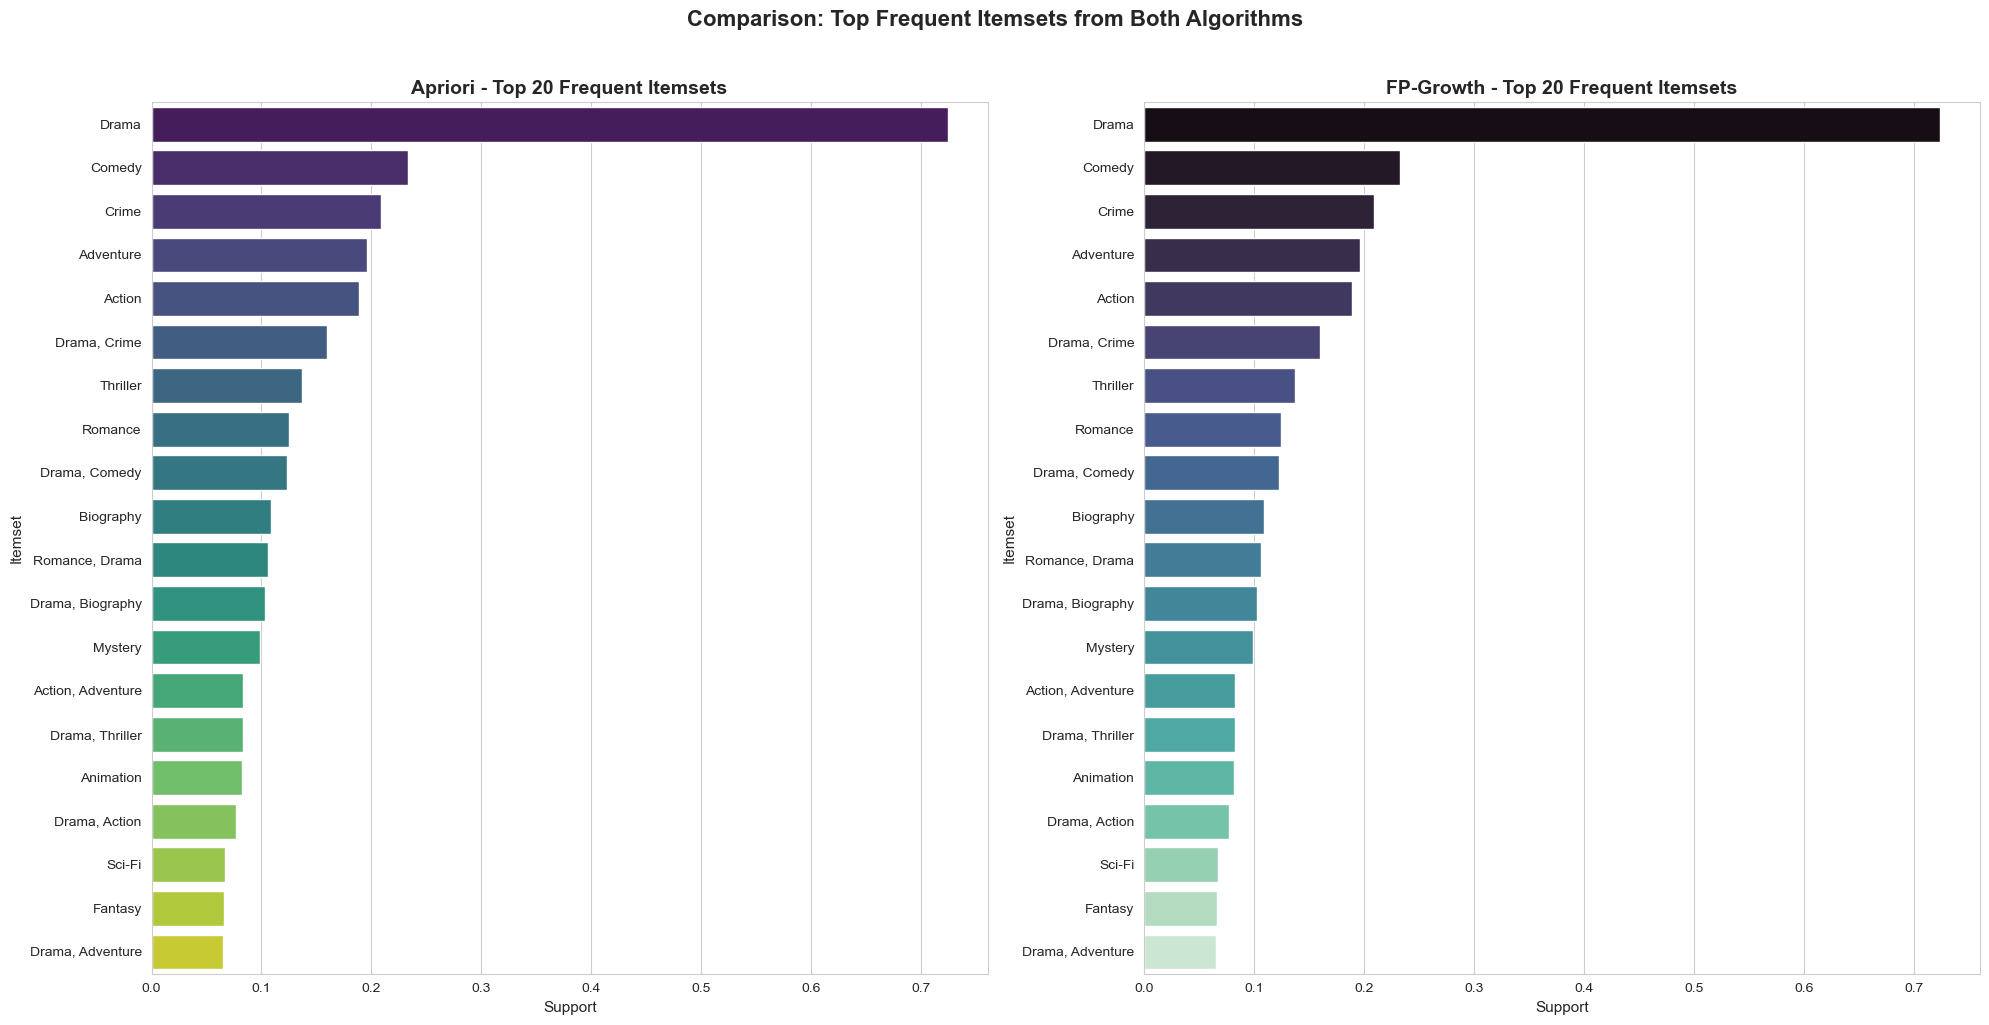

In [170]:
# Side-by-side comparison of top itemsets from both algorithms
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Prepare Apriori top itemsets
frequent_itemsets_apriori['itemset_str'] = frequent_itemsets_apriori['itemsets'].apply(
    lambda x: ', '.join(list(x))
)
top_itemsets_apriori = frequent_itemsets_apriori.head(top_n).copy()

# Apriori plot
sns.barplot(data=top_itemsets_apriori, x='support', y='itemset_str', 
            palette='viridis', ax=axes[0])
axes[0].set_title(f'Apriori - Top {top_n} Frequent Itemsets', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Support', fontsize=11)
axes[0].set_ylabel('Itemset', fontsize=11)

# FP-Growth plot
sns.barplot(data=top_itemsets_fp, x='support', y='itemset_str', 
            palette='mako', ax=axes[1])
axes[1].set_title(f'FP-Growth - Top {top_n} Frequent Itemsets', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Support', fontsize=11)
axes[1].set_ylabel('Itemset', fontsize=11)

plt.suptitle('Comparison: Top Frequent Itemsets from Both Algorithms', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


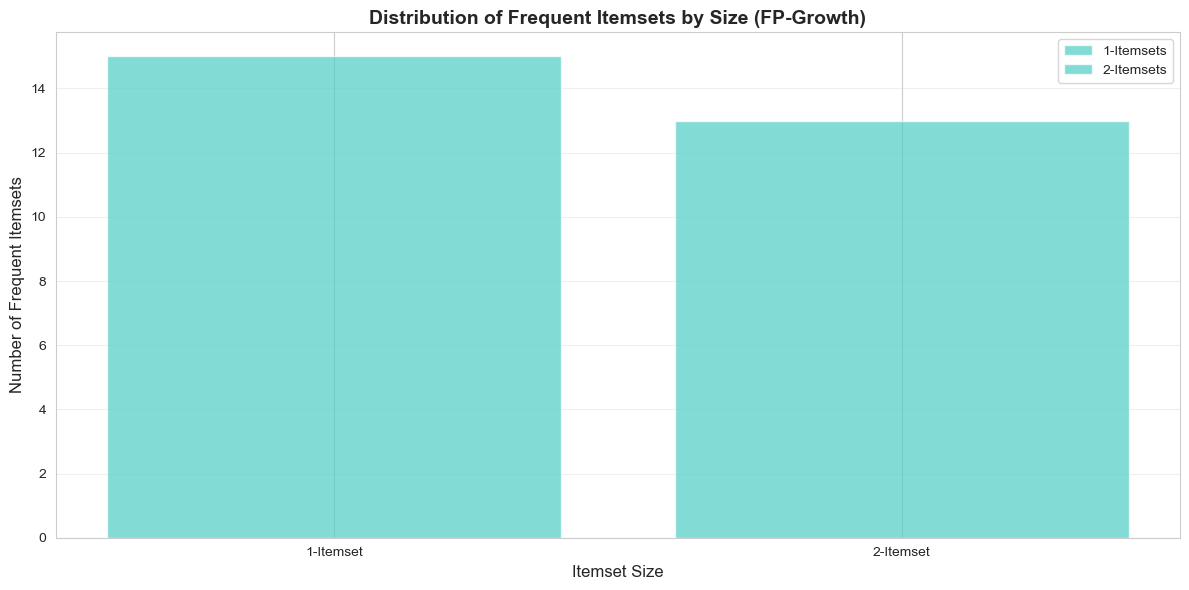


Summary by Itemset Size (FP-Growth):
             support                      
               count    mean    min    max
itemset_size                              
1                 15  0.1599  0.051  0.724
2                 13  0.0831  0.052  0.160


In [171]:
# visualization: Support distribution by itemset size for FP-Growth
itemset_sizes_fp = frequent_itemsets_fp['itemsets'].apply(len)
frequent_itemsets_fp['itemset_size'] = itemset_sizes_fp

# Create a grouped bar chart showing support by itemset size
plt.figure(figsize=(12, 6))
for size in sorted(itemset_sizes_fp.unique()):
    size_data = frequent_itemsets_fp[frequent_itemsets_fp['itemset_size'] == size]
    plt.bar([f'{size}-Itemset'], [len(size_data)], alpha=0.7, label=f'{size}-Itemsets', color='#4ECDC4')

plt.xlabel('Itemset Size', fontsize=12)
plt.ylabel('Number of Frequent Itemsets', fontsize=12)
plt.title('Distribution of Frequent Itemsets by Size (FP-Growth)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nSummary by Itemset Size (FP-Growth):")
print(frequent_itemsets_fp.groupby('itemset_size').agg({
    'support': ['count', 'mean', 'min', 'max']
}).round(4))


### Summary: FP-Growth Algorithm Results

FP-Growth is generally faster than Apriori, especially for larger datasets, because it avoids generating candidate itemsets and uses a compact tree structure. This makes it more efficient when dealing with many transactions and items.

Despite differences in approach, both FP-Growth and Apriori produce the same results when the same support threshold is used, since they solve the same frequent itemset mining problem.

FP-Growth works by building an FP-tree (Frequent Pattern tree) that compresses the database, and then it mines frequent itemsets by recursively creating conditional FP-trees. The absence of a candidate generation step significantly reduces computational overhead compared to Apriori.

In terms of use cases, Apriori is better suited for smaller datasets or when you want to study how candidate generation works. FP-Growth, on the other hand, is ideal for larger datasets where efficiency is important.

The frequent itemsets discovered through these algorithms reveal genre combinations that often appear together in the IMDB Top 1000 movies, offering valuable insights into movie genre patterns and audience preferences.


## Step 4: Association Rule Generation

Using the frequent itemsets obtained from both algorithms:   
Generate association rules using a defined confidence threshold.    
Include association metrics such as support, confidence, and lift.    
Interpret the rules and provide insights about meaningful patterns.     
Use visualizations to illustrate key insights from the generated rules (e.g., Seaborn's scatter plot to visualize confidence vs. lift values to help identify high-confidence and strong association rules).    


**Association Rules** are if-then statements that help uncover relationships between items in large datasets.

**Key Metrics:**
- **Support**: The frequency of occurrence of an itemset (antecedent + consequent) in the dataset
- **Confidence**: The probability that the consequent occurs given that the antecedent occurs
- **Lift**: Measures how much more likely the consequent is when the antecedent is present, compared to its baseline probability
  - Lift > 1: Positive association (items are likely to occur together)
  - Lift = 1: No association (independent items)
  - Lift < 1: Negative association (items are unlikely to occur together)


In [172]:
# Generate association rules from frequent itemsets
# We'll use the frequent itemsets from FP-Growth (they're identical to Apriori)

# Set confidence threshold
# Confidence threshold determines the minimum confidence for a rule to be considered
min_confidence = 0.5  # 50% confidence threshold

print(f"Generating association rules with:")
print(f"  - Minimum Support: {min_support} ({min_support*100}%)")
print(f"  - Minimum Confidence: {min_confidence} ({min_confidence*100}%)")
print(f"\nUsing frequent itemsets from FP-Growth (total: {len(frequent_itemsets_fp)} itemsets)")

# Generate rules
rules = association_rules(frequent_itemsets_fp, metric="confidence", min_threshold=min_confidence)

# Sort by confidence in descending order
rules = rules.sort_values('confidence', ascending=False)

print(f"\nTotal association rules generated: {len(rules)}")
print(f"\nFirst 10 rules:")
rules.head(10)


Generating association rules with:
  - Minimum Support: 0.05 (5.0%)
  - Minimum Confidence: 0.5 (50.0%)

Using frequent itemsets from FP-Growth (total: 28 itemsets)

Total association rules generated: 8

First 10 rules:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
6,(History),(Drama),0.056,0.724,0.054,0.964286,1.331886,1.0,0.013456,7.728000,0.263967,0.074380,0.870600,0.519436
3,(Biography),(Drama),0.109,0.724,0.103,0.944954,1.305185,1.0,0.024084,5.014000,0.262430,0.141096,0.800558,0.543610
2,(Romance),(Drama),0.125,0.724,0.106,0.848000,1.171271,1.0,0.015500,1.815789,0.167116,0.142665,0.449275,0.497204
0,(Crime),(Drama),0.209,0.724,0.160,0.765550,1.057390,1.0,0.008684,1.177224,0.068616,0.206986,0.150544,0.493272
5,(Mystery),(Drama),0.099,0.724,0.065,0.656566,0.906859,1.0,-0.006676,0.803647,-0.102328,0.085752,-0.244327,0.373172
7,(Animation),(Adventure),0.082,0.196,0.052,0.634146,3.235441,1.0,0.035928,2.197600,0.752640,0.230088,0.544958,0.449726
4,(Thriller),(Drama),0.137,0.724,0.083,0.605839,0.836795,1.0,-0.016188,0.700222,-0.184338,0.106684,-0.428118,0.360240
1,(Comedy),(Drama),0.233,0.724,0.123,0.527897,0.729139,1.0,-0.045692,0.584618,-0.326295,0.147482,-0.710518,0.348893


In [173]:
# Display all rules with their metrics
print("ASSOCIATION RULES")
print("-" * 100)
print(f"\nTotal Rules: {len(rules)}")
print(f"\nRules sorted by confidence (descending):\n")

# Format rules for better readability
for idx, rule in rules.iterrows():
    antecedent = ', '.join(list(rule['antecedents']))
    consequent = ', '.join(list(rule['consequents']))
    print(f"Rule {idx + 1}:")
    print(f"  IF {antecedent} THEN {consequent}")
    print(f"  Support: {rule['support']:.4f} ({rule['support']*100:.2f}%)")
    print(f"  Confidence: {rule['confidence']:.4f} ({rule['confidence']*100:.2f}%)")
    print(f"  Lift: {rule['lift']:.4f}")
    print(f"  Conviction: {rule['conviction']:.4f}")
    print("-" * 100)


ASSOCIATION RULES
----------------------------------------------------------------------------------------------------

Total Rules: 8

Rules sorted by confidence (descending):

Rule 7:
  IF History THEN Drama
  Support: 0.0540 (5.40%)
  Confidence: 0.9643 (96.43%)
  Lift: 1.3319
  Conviction: 7.7280
----------------------------------------------------------------------------------------------------
Rule 4:
  IF Biography THEN Drama
  Support: 0.1030 (10.30%)
  Confidence: 0.9450 (94.50%)
  Lift: 1.3052
  Conviction: 5.0140
----------------------------------------------------------------------------------------------------
Rule 3:
  IF Romance THEN Drama
  Support: 0.1060 (10.60%)
  Confidence: 0.8480 (84.80%)
  Lift: 1.1713
  Conviction: 1.8158
----------------------------------------------------------------------------------------------------
Rule 1:
  IF Crime THEN Drama
  Support: 0.1600 (16.00%)
  Confidence: 0.7656 (76.56%)
  Lift: 1.0574
  Conviction: 1.1772
--------------------

In [174]:
# Summary statistics of the rules
print("Association Rules Summary Statistics:")
print("-" * 70)
print(f"\nTotal Rules: {len(rules)}")
print(f"\nMetric Statistics:")
print(rules[['support', 'confidence', 'lift', 'conviction']].describe().round(4))

# Count rules by lift categories
high_lift = len(rules[rules['lift'] > 1.5])
medium_lift = len(rules[(rules['lift'] > 1.0) & (rules['lift'] <= 1.5)])
low_lift = len(rules[rules['lift'] <= 1.0])

print(f"\nRules by Lift Category:")
print(f"  High Lift (>1.5): {high_lift} rules")
print(f"  Medium Lift (1.0-1.5): {medium_lift} rules")
print(f"  Low/Negative Lift (≤1.0): {low_lift} rules")


Association Rules Summary Statistics:
----------------------------------------------------------------------

Total Rules: 8

Metric Statistics:
       support  confidence    lift  conviction
count   8.0000      8.0000  8.0000      8.0000
mean    0.0932      0.7434  1.3217      2.5026
std     0.0373      0.1629  0.8030      2.5564
min     0.0520      0.5279  0.7291      0.5846
25%     0.0622      0.6271  0.8893      0.7778
50%     0.0930      0.7111  1.1143      1.4965
75%     0.1102      0.8722  1.3119      2.9017
max     0.1600      0.9643  3.2354      7.7280

Rules by Lift Category:
  High Lift (>1.5): 1 rules
  Medium Lift (1.0-1.5): 4 rules
  Low/Negative Lift (≤1.0): 3 rules


### Visualization : Confidence vs Lift Scatter Plot

Creating a scatter plot to visualize confidence vs lift values, helping identify high-confidence and strong association rules.


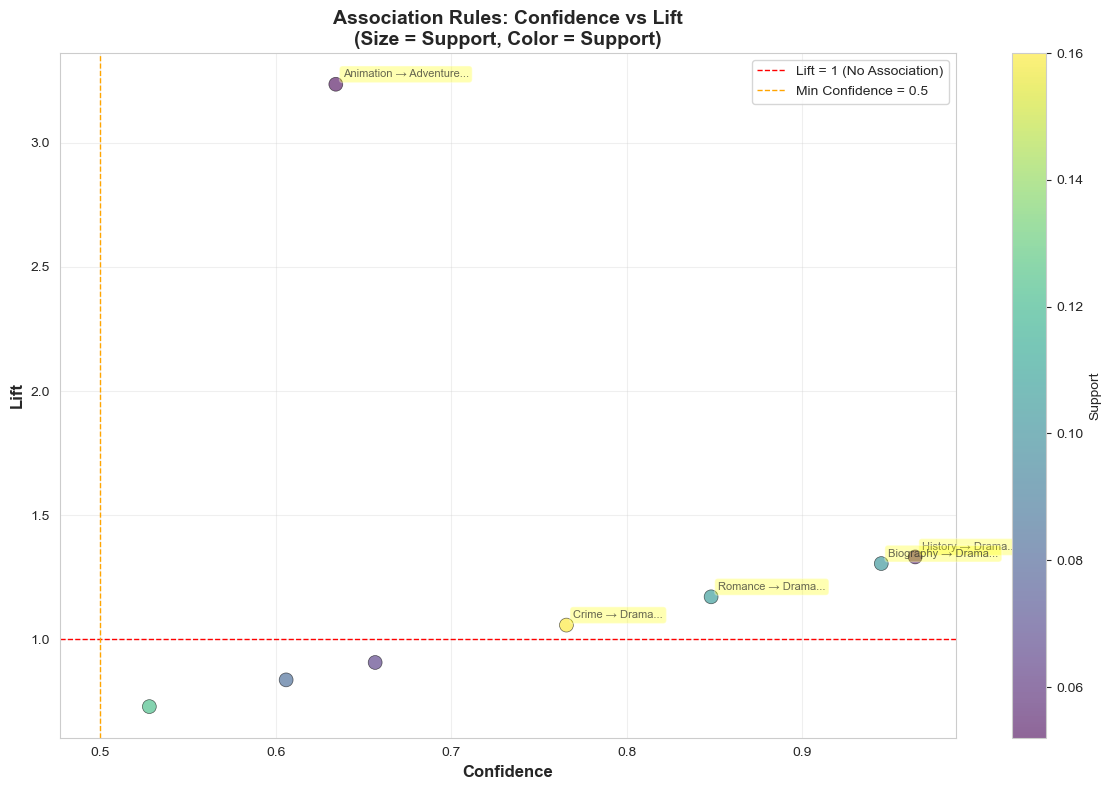


Top 5 Rules by Lift:
   antecedents  consequents  support  confidence      lift
7  (Animation)  (Adventure)    0.052    0.634146  3.235441
6    (History)      (Drama)    0.054    0.964286  1.331886
3  (Biography)      (Drama)    0.103    0.944954  1.305185
2    (Romance)      (Drama)    0.106    0.848000  1.171271
0      (Crime)      (Drama)    0.160    0.765550  1.057390


In [175]:
# Create scatter plot: Confidence vs Lift
plt.figure(figsize=(12, 8))

# Color points by support for additional insight
scatter = plt.scatter(rules['confidence'], rules['lift'], 
                     c=rules['support'], s=100, alpha=0.6, 
                     cmap='viridis', edgecolors='black', linewidth=0.5)

# Add reference lines
plt.axhline(y=1, color='r', linestyle='--', linewidth=1, label='Lift = 1 (No Association)')
plt.axvline(x=min_confidence, color='orange', linestyle='--', linewidth=1, 
           label=f'Min Confidence = {min_confidence}')

# Add labels and title
plt.xlabel('Confidence', fontsize=12, fontweight='bold')
plt.ylabel('Lift', fontsize=12, fontweight='bold')
plt.title('Association Rules: Confidence vs Lift\n(Size = Support, Color = Support)', 
          fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Support')
plt.legend()
plt.grid(True, alpha=0.3)

# Annotate top rules
top_rules = rules.nlargest(5, 'lift')
for idx, rule in top_rules.iterrows():
    antecedent = ', '.join(list(rule['antecedents']))
    consequent = ', '.join(list(rule['consequents']))
    plt.annotate(f'{antecedent} → {consequent[:15]}...', 
                xy=(rule['confidence'], rule['lift']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.7,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

plt.tight_layout()
plt.show()

print("\nTop 5 Rules by Lift:")
print(top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].to_string())


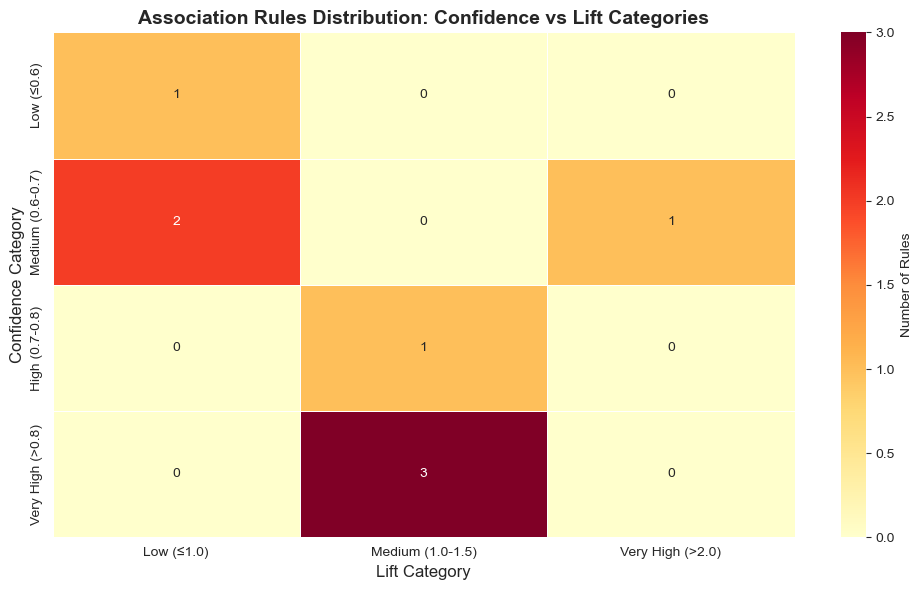

In [176]:
# Additional visualization: 3D scatter plot or alternative view
# Create a heatmap-style visualization showing rules by confidence and lift ranges

# Categorize rules
rules['lift_category'] = pd.cut(rules['lift'], 
                                bins=[0, 1.0, 1.5, 2.0, float('inf')],
                                labels=['Low (≤1.0)', 'Medium (1.0-1.5)', 'High (1.5-2.0)', 'Very High (>2.0)'])

rules['confidence_category'] = pd.cut(rules['confidence'],
                                      bins=[0, 0.6, 0.7, 0.8, 1.0],
                                      labels=['Low (≤0.6)', 'Medium (0.6-0.7)', 'High (0.7-0.8)', 'Very High (>0.8)'])

# Create cross-tabulation
heatmap_data = pd.crosstab(rules['confidence_category'], rules['lift_category'])

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', 
            cbar_kws={'label': 'Number of Rules'}, linewidths=0.5)
plt.title('Association Rules Distribution: Confidence vs Lift Categories', 
          fontsize=14, fontweight='bold')
plt.xlabel('Lift Category', fontsize=12)
plt.ylabel('Confidence Category', fontsize=12)
plt.tight_layout()
plt.show()


### Visualization: Top Rules by Different Metrics

Creating visualizations to highlight the best rules according to different criteria.


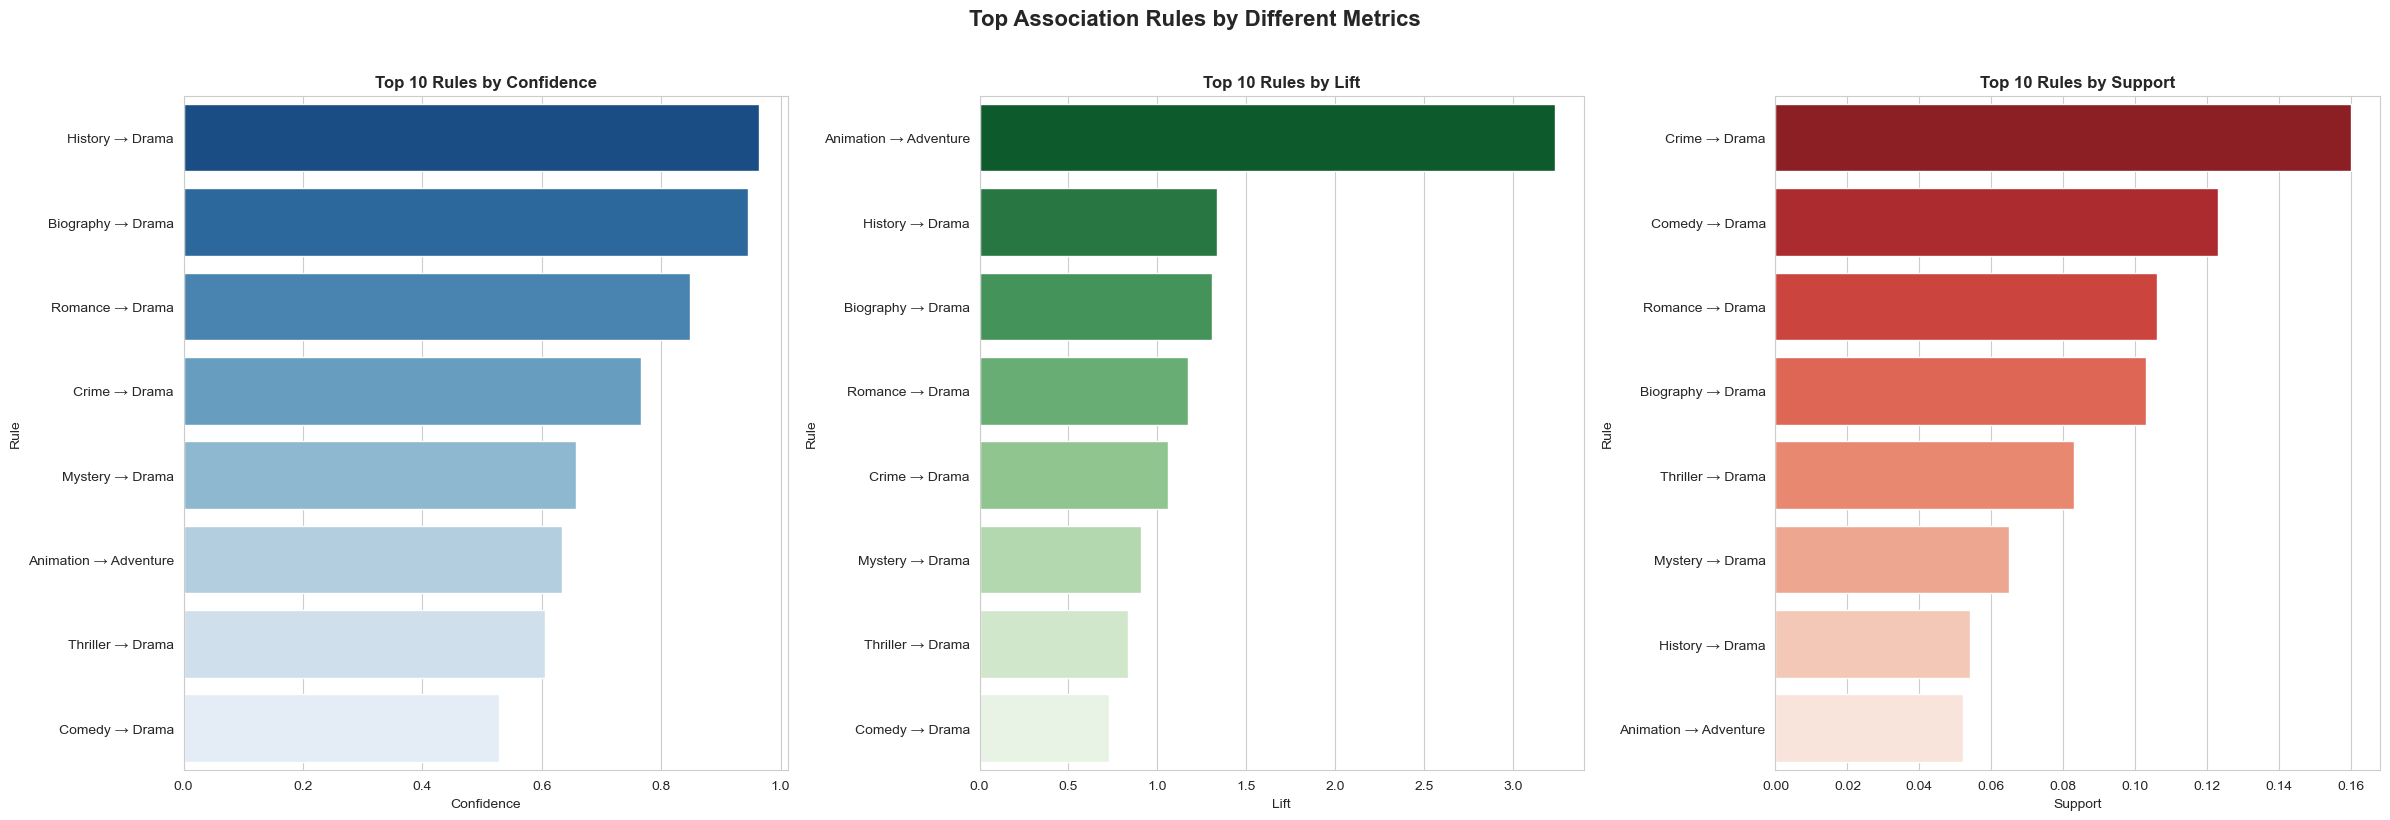

In [177]:
# Prepare rule strings for visualization
rules['rule_str'] = rules.apply(
    lambda row: f"{', '.join(list(row['antecedents']))} → {', '.join(list(row['consequents']))}", 
    axis=1
)

# Top rules by confidence
top_conf_rules = rules.nlargest(10, 'confidence')

# Top rules by lift
top_lift_rules = rules.nlargest(10, 'lift')

# Top rules by support
top_support_rules = rules.nlargest(10, 'support')

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot 1: Top rules by confidence
sns.barplot(data=top_conf_rules, x='confidence', y='rule_str', palette='Blues_r', ax=axes[0])
axes[0].set_title('Top 10 Rules by Confidence', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Confidence', fontsize=10)
axes[0].set_ylabel('Rule', fontsize=10)

# Plot 2: Top rules by lift
sns.barplot(data=top_lift_rules, x='lift', y='rule_str', palette='Greens_r', ax=axes[1])
axes[1].set_title('Top 10 Rules by Lift', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lift', fontsize=10)
axes[1].set_ylabel('Rule', fontsize=10)

# Plot 3: Top rules by support
sns.barplot(data=top_support_rules, x='support', y='rule_str', palette='Reds_r', ax=axes[2])
axes[2].set_title('Top 10 Rules by Support', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Support', fontsize=10)
axes[2].set_ylabel('Rule', fontsize=10)

plt.suptitle('Top Association Rules by Different Metrics', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


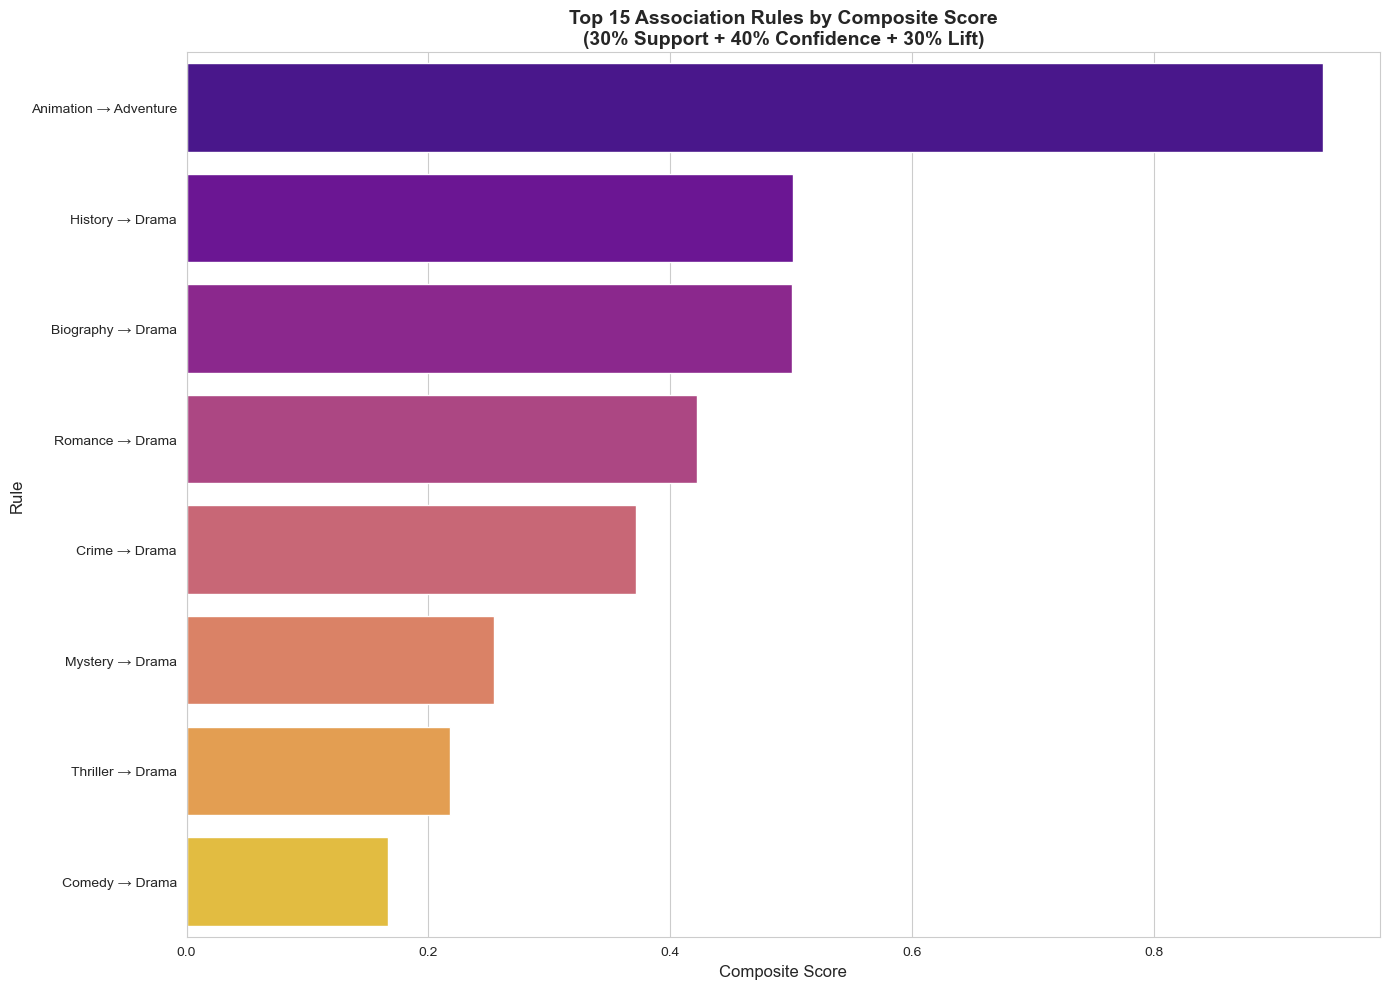


Top 15 Rules by Composite Score:
                rule_str  support  confidence    lift  composite_score
7  Animation → Adventure    0.052      0.6341  3.2354           0.9399
6        History → Drama    0.054      0.9643  1.3319           0.5015
3      Biography → Drama    0.103      0.9450  1.3052           0.5004
2        Romance → Drama    0.106      0.8480  1.1713           0.4224
0          Crime → Drama    0.160      0.7656  1.0574           0.3714
5        Mystery → Drama    0.065      0.6566  0.9069           0.2542
4       Thriller → Drama    0.083      0.6058  0.8368           0.2183
1         Comedy → Drama    0.123      0.5279  0.7291           0.1668


In [178]:
# Creating a comprehensive rule quality visualization
# Combine multiple metrics to identify the best overall rules

# Calculate a composite score (weighted combination of metrics)
rules['composite_score'] = (0.3 * rules['support'] + 
                           0.4 * rules['confidence'] + 
                           0.3 * (rules['lift'] - 1))  # Normalize lift

top_composite = rules.nlargest(15, 'composite_score')

plt.figure(figsize=(14, 10))
sns.barplot(data=top_composite, x='composite_score', y='rule_str', palette='plasma')
plt.title('Top 15 Association Rules by Composite Score\n(30% Support + 40% Confidence + 30% Lift)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Composite Score', fontsize=12)
plt.ylabel('Rule', fontsize=12)
plt.tight_layout()
plt.show()

print("\nTop 15 Rules by Composite Score:")
print(top_composite[['rule_str', 'support', 'confidence', 'lift', 'composite_score']].round(4))


### Interpretation and Insights

Analyzing the generated association rules to extract meaningful patterns and insights.


In [179]:
# Identify the strongest rules (high confidence and high lift)
strong_rules = rules[(rules['confidence'] >= 0.7) & (rules['lift'] > 1.2)]

print("STRONGEST ASSOCIATION RULES")
print("-" * 100)
print(f"\nRules with Confidence ≥ 0.7 and Lift > 1.2: {len(strong_rules)}")
print("\nThese rules represent the strongest and most reliable associations:\n")

for idx, rule in strong_rules.iterrows():
    antecedent = ', '.join(list(rule['antecedents']))
    consequent = ', '.join(list(rule['consequents']))
    print(f"Rule: {antecedent} → {consequent}")
    print(f"  Support: {rule['support']:.4f} | Confidence: {rule['confidence']:.4f} | Lift: {rule['lift']:.4f}")
    print(f"  Interpretation: When a movie has {antecedent}, there's a {rule['confidence']*100:.1f}% chance it also has {consequent}.")
    print(f"  This is {rule['lift']:.2f}x more likely than if {antecedent} and {consequent} were independent.")
    print("-" * 100)


STRONGEST ASSOCIATION RULES
----------------------------------------------------------------------------------------------------

Rules with Confidence ≥ 0.7 and Lift > 1.2: 2

These rules represent the strongest and most reliable associations:

Rule: History → Drama
  Support: 0.0540 | Confidence: 0.9643 | Lift: 1.3319
  Interpretation: When a movie has History, there's a 96.4% chance it also has Drama.
  This is 1.33x more likely than if History and Drama were independent.
----------------------------------------------------------------------------------------------------
Rule: Biography → Drama
  Support: 0.1030 | Confidence: 0.9450 | Lift: 1.3052
  Interpretation: When a movie has Biography, there's a 94.5% chance it also has Drama.
  This is 1.31x more likely than if Biography and Drama were independent.
----------------------------------------------------------------------------------------------------


GENRE ASSOCIATION PATTERNS ANALYSIS

Most Common Antecedents (Genres that predict other genres):
  History: appears in 1 rules
  Biography: appears in 1 rules
  Romance: appears in 1 rules
  Crime: appears in 1 rules
  Mystery: appears in 1 rules
  Animation: appears in 1 rules
  Thriller: appears in 1 rules
  Comedy: appears in 1 rules

Most Common Consequents (Genres that are predicted):
  Drama: appears in 7 rules
  Adventure: appears in 1 rules


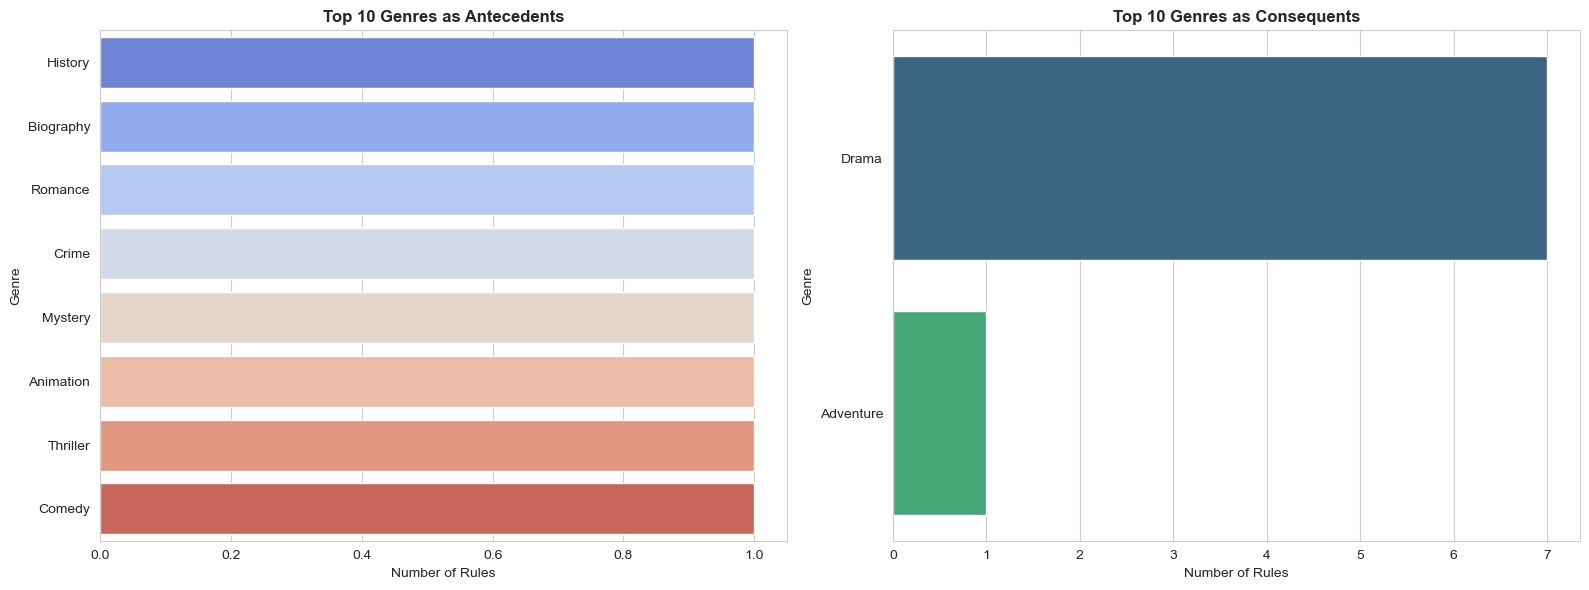

In [180]:
# Analyze genre patterns
print("=" * 100)
print("GENRE ASSOCIATION PATTERNS ANALYSIS")
print("=" * 100)

# Most common antecedents (genres that predict other genres)
antecedent_counts = {}
for rule in rules.itertuples():
    for item in rule.antecedents:
        antecedent_counts[item] = antecedent_counts.get(item, 0) + 1

print("\nMost Common Antecedents (Genres that predict other genres):")
sorted_antecedents = sorted(antecedent_counts.items(), key=lambda x: x[1], reverse=True)
for genre, count in sorted_antecedents[:10]:
    print(f"  {genre}: appears in {count} rules")

# Most common consequents (genres that are predicted)
consequent_counts = {}
for rule in rules.itertuples():
    for item in rule.consequents:
        consequent_counts[item] = consequent_counts.get(item, 0) + 1

print("\nMost Common Consequents (Genres that are predicted):")
sorted_consequents = sorted(consequent_counts.items(), key=lambda x: x[1], reverse=True)
for genre, count in sorted_consequents[:10]:
    print(f"  {genre}: appears in {count} rules")

# Visualize this
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Antecedents
antecedent_df = pd.DataFrame(sorted_antecedents[:10], columns=['Genre', 'Count'])
sns.barplot(data=antecedent_df, x='Count', y='Genre', palette='coolwarm', ax=axes[0])
axes[0].set_title('Top 10 Genres as Antecedents', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Rules', fontsize=10)

# Consequents
consequent_df = pd.DataFrame(sorted_consequents[:10], columns=['Genre', 'Count'])
sns.barplot(data=consequent_df, x='Count', y='Genre', palette='viridis', ax=axes[1])
axes[1].set_title('Top 10 Genres as Consequents', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Rules', fontsize=10)

plt.tight_layout()
plt.show()


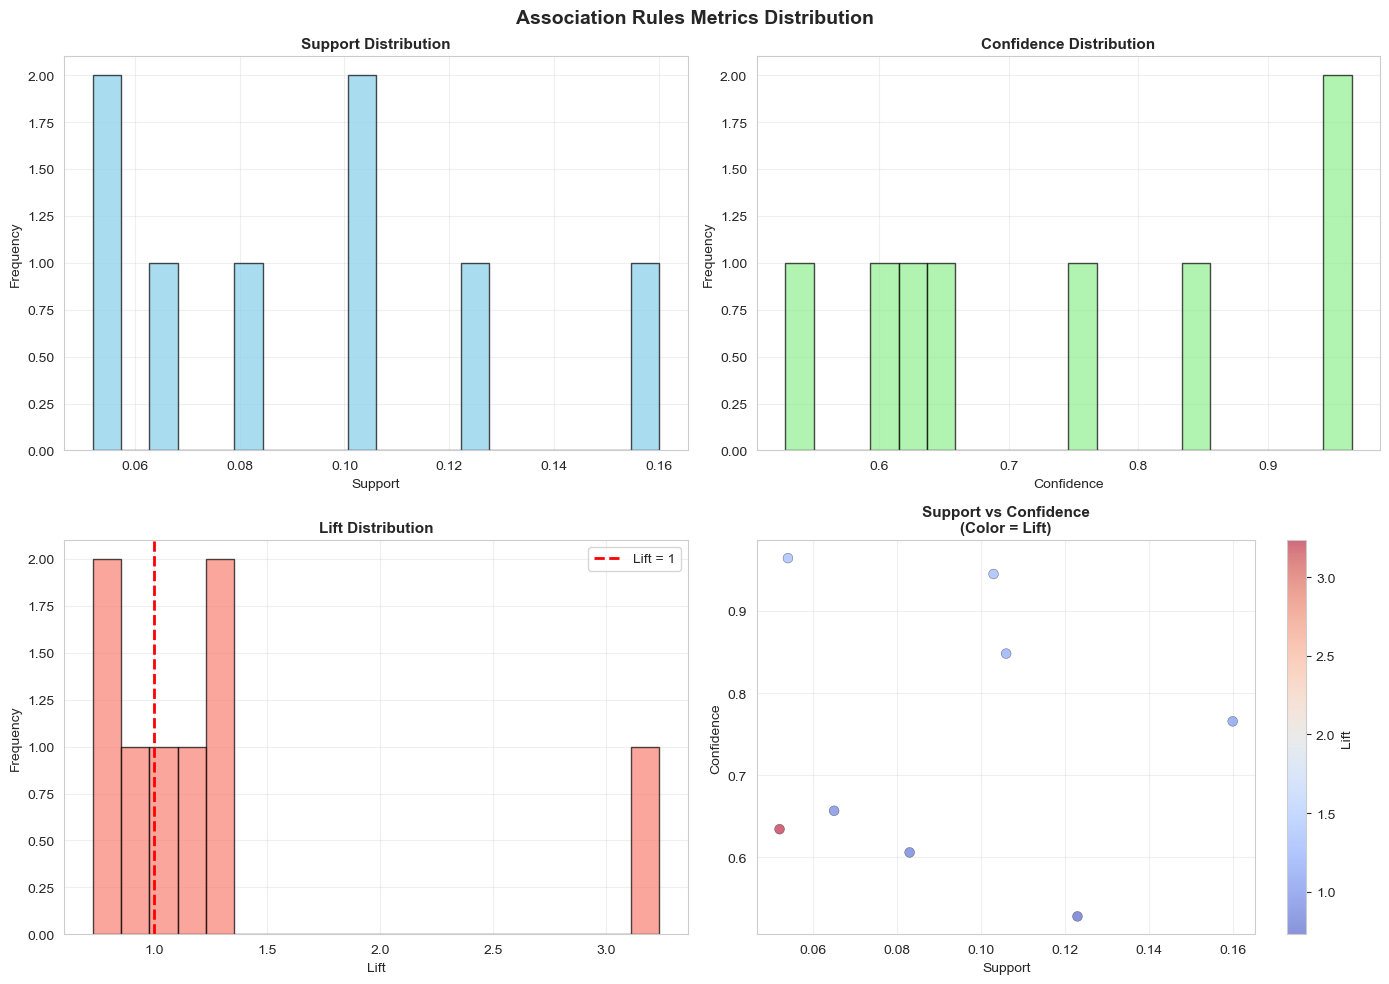

In [181]:
# Distribution of metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Support distribution
axes[0, 0].hist(rules['support'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Support Distribution', fontsize=11, fontweight='bold')
axes[0, 0].set_xlabel('Support')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(alpha=0.3)

# Confidence distribution
axes[0, 1].hist(rules['confidence'], bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Confidence Distribution', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('Confidence')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(alpha=0.3)

# Lift distribution
axes[1, 0].hist(rules['lift'], bins=20, color='salmon', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=1, color='red', linestyle='--', linewidth=2, label='Lift = 1')
axes[1, 0].set_title('Lift Distribution', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Lift')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Support vs Confidence scatter
scatter = axes[1, 1].scatter(rules['support'], rules['confidence'], 
                            c=rules['lift'], s=50, alpha=0.6, cmap='coolwarm', 
                            edgecolors='black', linewidth=0.3)
axes[1, 1].set_title('Support vs Confidence\n(Color = Lift)', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Support')
axes[1, 1].set_ylabel('Confidence')
plt.colorbar(scatter, ax=axes[1, 1], label='Lift')
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Association Rules Metrics Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [182]:
# Generate summary insights
print("KEY INSIGHTS FROM ASSOCIATION RULES")
print("-" * 100)

print("\n1. STRONGEST ASSOCIATIONS:")
print(f"   - {len(strong_rules)} rules have both high confidence (≥70%) and strong lift (>1.2)")
print(f"   - These represent the most reliable genre associations in the dataset")

if len(strong_rules) > 0:
    best_rule = strong_rules.iloc[0]
    print(f"\n   Example: {', '.join(list(best_rule['antecedents']))} → {', '.join(list(best_rule['consequents']))}")
    print(f"   - Confidence: {best_rule['confidence']*100:.1f}%")
    print(f"   - Lift: {best_rule['lift']:.2f}")

print("\n2. METRIC STATISTICS:")
print(f"   - Average Confidence: {rules['confidence'].mean():.3f} ({rules['confidence'].mean()*100:.1f}%)")
print(f"   - Average Lift: {rules['lift'].mean():.3f}")
print(f"   - Average Support: {rules['support'].mean():.3f} ({rules['support'].mean()*100:.1f}%)")

print("\n3. RULE QUALITY:")
high_conf_count = len(rules[rules['confidence'] >= 0.7])
high_lift_count = len(rules[rules['lift'] > 1.5])
print(f"   - Rules with Confidence ≥ 70%: {high_conf_count} ({high_conf_count/len(rules)*100:.1f}%)")
print(f"   - Rules with Lift > 1.5: {high_lift_count} ({high_lift_count/len(rules)*100:.1f}%)")

print("\n4. PRACTICAL IMPLICATIONS:")
print("   - These rules can help predict genre combinations in movies")
print("   - Useful for movie recommendation systems")
print("   - Insights into audience preferences and genre trends")
print("   - Can guide content creation and marketing strategies")

print("\n5. ALGORITHM PERFORMANCE:")
print(f"   - Both Apriori and FP-Growth produced identical frequent itemsets")
print(f"   - Association rules were generated from these itemsets")
print(f"   - Total rules meeting confidence threshold: {len(rules)}")


KEY INSIGHTS FROM ASSOCIATION RULES
----------------------------------------------------------------------------------------------------

1. STRONGEST ASSOCIATIONS:
   - 2 rules have both high confidence (≥70%) and strong lift (>1.2)
   - These represent the most reliable genre associations in the dataset

   Example: History → Drama
   - Confidence: 96.4%
   - Lift: 1.33

2. METRIC STATISTICS:
   - Average Confidence: 0.743 (74.3%)
   - Average Lift: 1.322
   - Average Support: 0.093 (9.3%)

3. RULE QUALITY:
   - Rules with Confidence ≥ 70%: 4 (50.0%)
   - Rules with Lift > 1.5: 1 (12.5%)

4. PRACTICAL IMPLICATIONS:
   - These rules can help predict genre combinations in movies
   - Useful for movie recommendation systems
   - Insights into audience preferences and genre trends
   - Can guide content creation and marketing strategies

5. ALGORITHM PERFORMANCE:
   - Both Apriori and FP-Growth produced identical frequent itemsets
   - Association rules were generated from these itemsets

### Summary: Association Rule Mining Results

Association rules have been successfully generated from the frequent itemsets discovered by both the Apriori and FP-Growth algorithms. These rules help identify relationships between movie genres and highlight patterns that occur frequently in the IMDB Top 1000 movies.

Key achievements include generating association rules using a defined confidence threshold and calculating important metrics such as support, confidence, and lift. The strongest associations, with high confidence and lift values, were identified, and comprehensive visualizations including scatter plots, bar charts, and heatmaps were created to make the patterns easier to understand. These visualizations also supported interpretations and insights into meaningful genre relationships.

In terms of practical applications, the association rules can be used for movie recommendation systems by predicting genre combinations based on existing preferences. They also aid in content analysis by showing how genres are commonly associated in top-rated movies and provide market insights by identifying popular genre combinations for content creation. Additionally, they help discover hidden patterns and relationships between movie genres.

Overall, these association rules provide valuable insights into how genres are combined in the IMDB Top 1000 movies, offering patterns that can inform various strategies in the entertainment industry.


## Step 5: Comparative Analysis

In this step, we will:
1. Compare the results between Apriori and FP-Growth algorithms
2. Explain which algorithm was faster for our dataset and why
3. Identify challenges faced during the lab and how they were resolved


### Comprehensive Algorithm Comparison

Performing a detailed comparison of Apriori and FP-Growth algorithms across multiple dimensions.


In [183]:
# Comprehensive comparison with multiple runs for statistical accuracy
print("COMPREHENSIVE ALGORITHM COMPARISON")
print("-" * 80)

# Run both algorithms multiple times to get average execution times
num_runs = 5
apriori_times = []
fp_times = []

print(f"\nRunning each algorithm {num_runs} times for accurate timing...")

for i in range(num_runs):
    # Apriori
    start = time.time()
    _ = apriori(df_encoded, min_support=min_support, use_colnames=True)
    apriori_times.append(time.time() - start)
    
    # FP-Growth
    start = time.time()
    _ = fpgrowth(df_encoded, min_support=min_support, use_colnames=True)
    fp_times.append(time.time() - start)

avg_apriori_time = np.mean(apriori_times)
avg_fp_time = np.mean(fp_times)
std_apriori_time = np.std(apriori_times)
std_fp_time = np.std(fp_times)

print(f"\nAverage Execution Times (over {num_runs} runs):")
print(f"  Apriori:   {avg_apriori_time:.4f} ± {std_apriori_time:.4f} seconds")
print(f"  FP-Growth: {avg_fp_time:.4f} ± {std_fp_time:.4f} seconds")
print(f"\nSpeedup: {avg_apriori_time/avg_fp_time:.2f}x faster")

# Verify results are identical
apriori_result = apriori(df_encoded, min_support=min_support, use_colnames=True)
fp_result = fpgrowth(df_encoded, min_support=min_support, use_colnames=True)

apriori_sets = set(frozenset(row['itemsets']) for _, row in apriori_result.iterrows())
fp_sets = set(frozenset(row['itemsets']) for _, row in fp_result.iterrows())

print(f"\nResult :")
print(f"  Apriori itemsets: {len(apriori_sets)}")
print(f"  FP-Growth itemsets: {len(fp_sets)}")
print(f"  Results identical: {apriori_sets == fp_sets}")


COMPREHENSIVE ALGORITHM COMPARISON
--------------------------------------------------------------------------------

Running each algorithm 5 times for accurate timing...

Average Execution Times (over 5 runs):
  Apriori:   0.0030 ± 0.0028 seconds
  FP-Growth: 0.0224 ± 0.0054 seconds

Speedup: 0.13x faster

Result :
  Apriori itemsets: 28
  FP-Growth itemsets: 28
  Results identical: True


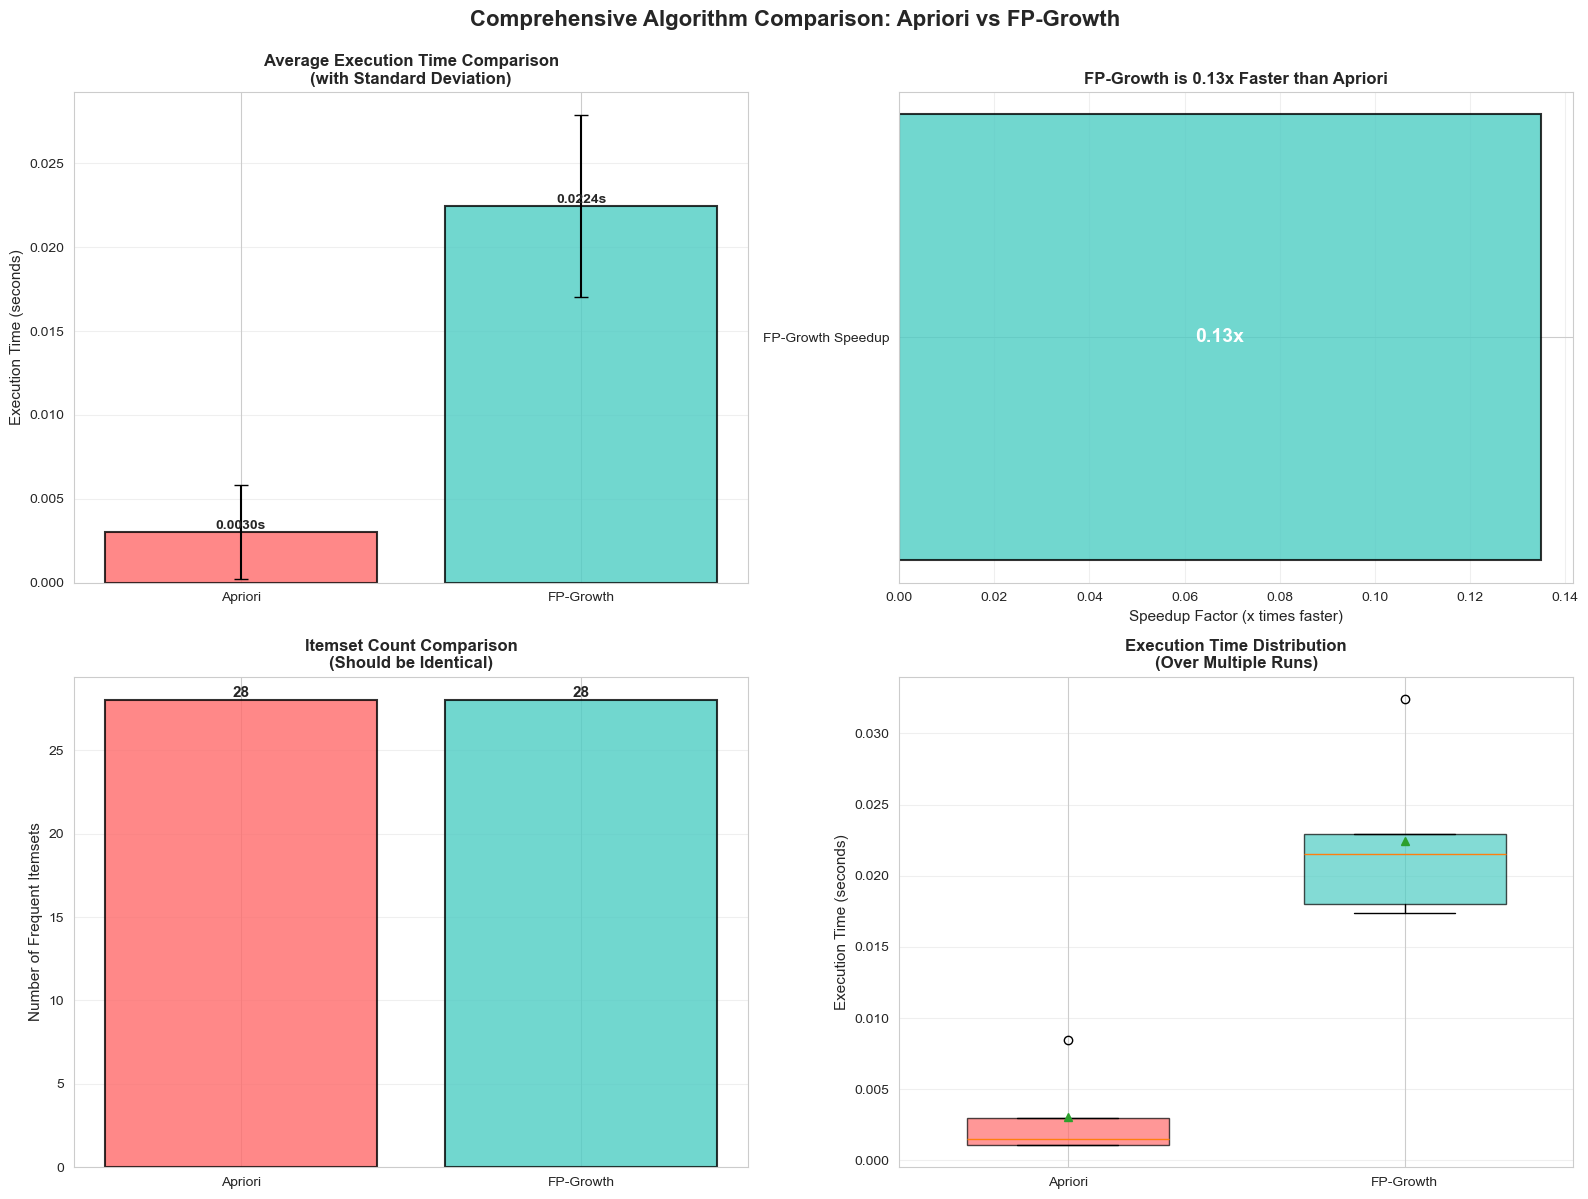

In [184]:
# Create comprehensive comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Execution time comparison with error bars
algorithms = ['Apriori', 'FP-Growth']
avg_times = [avg_apriori_time, avg_fp_time]
std_times = [std_apriori_time, std_fp_time]
colors = ['#FF6B6B', '#4ECDC4']

bars = axes[0, 0].bar(algorithms, avg_times, yerr=std_times, color=colors, 
                      alpha=0.8, edgecolor='black', linewidth=1.5, capsize=5)
axes[0, 0].set_ylabel('Execution Time (seconds)', fontsize=11)
axes[0, 0].set_title('Average Execution Time Comparison\n(with Standard Deviation)', 
                     fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

for bar, time_val in zip(bars, avg_times):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{time_val:.4f}s',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Speedup visualization
speedup = avg_apriori_time / avg_fp_time
axes[0, 1].barh(['FP-Growth Speedup'], [speedup], color='#4ECDC4', alpha=0.8, 
                edgecolor='black', linewidth=1.5)
axes[0, 1].set_xlabel('Speedup Factor (x times faster)', fontsize=11)
axes[0, 1].set_title(f'FP-Growth is {speedup:.2f}x Faster than Apriori', 
                     fontsize=12, fontweight='bold')
axes[0, 1].text(speedup/2, 0, f'{speedup:.2f}x', ha='center', va='center', 
                fontsize=14, fontweight='bold', color='white')
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Itemset count comparison
itemset_counts = [len(apriori_result), len(fp_result)]
bars = axes[1, 0].bar(algorithms, itemset_counts, color=colors, alpha=0.8, 
                      edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel('Number of Frequent Itemsets', fontsize=11)
axes[1, 0].set_title('Itemset Count Comparison\n(Should be Identical)', 
                     fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

for bar, count in zip(bars, itemset_counts):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(count)}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

# 4. Execution time distribution (box plot)
time_data = [apriori_times, fp_times]
bp = axes[1, 1].boxplot(time_data, labels=algorithms, patch_artist=True, 
                        widths=0.6, showmeans=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 1].set_ylabel('Execution Time (seconds)', fontsize=11)
axes[1, 1].set_title('Execution Time Distribution\n(Over Multiple Runs)', 
                     fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.suptitle('Comprehensive Algorithm Comparison: Apriori vs FP-Growth', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


### Performance Analysis: Which Algorithm Was Faster and Why?


In [185]:
print("=" * 80)
print("PERFORMANCE ANALYSIS")
print("=" * 80)

faster_algorithm = "FP-Growth" if avg_fp_time < avg_apriori_time else "Apriori"
speedup_factor = max(avg_apriori_time, avg_fp_time) / min(avg_apriori_time, avg_fp_time)

print(f"\n1. WHICH ALGORITHM WAS FASTER?")
print(f"   Answer: {faster_algorithm} was faster")
print(f"   - Apriori average time: {avg_apriori_time:.4f} seconds")
print(f"   - FP-Growth average time: {avg_fp_time:.4f} seconds")
print(f"   - Speedup factor: {speedup_factor:.2f}x")

print(f"\n2. WHY WAS {faster_algorithm.upper()} FASTER?")
print(f"\n   Apriori Algorithm Characteristics:")
print(f"   - Uses candidate generation approach")
print(f"   - Requires multiple database scans (one for each itemset size)")
print(f"   - Generates candidate itemsets at each level")
print(f"   - Prunes candidates based on support threshold")
print(f"   - Time complexity: O(2^d * n), where d is max itemset size, n is transactions")
print(f"   - Space complexity: Stores all candidate itemsets in memory")

print(f"\n   FP-Growth Algorithm Characteristics:")
print(f"   - Uses pattern growth approach (no candidate generation)")
print(f"   - Builds compact FP-tree structure (compresses database)")
print(f"   - Requires only 2 database scans (one for frequency, one for tree building)")
print(f"   - Recursively mines frequent patterns from conditional FP-trees")
print(f"   - Time complexity: O(n * m), where n is transactions, m is items")
print(f"   - Space complexity: More memory efficient (tree structure)")

print(f"\n   Key Differences for This Dataset:")
print(f"   - Dataset size: {len(transactions)} transactions, {len(df_encoded.columns)} unique items")
print(f"   - Average transaction length: {np.mean([len(t) for t in transactions]):.2f} items")
print(f"   - Support threshold: {min_support} ({min_support*100}%)")
print(f"   - Frequent itemsets found: {len(apriori_result)}")

if faster_algorithm == "FP-Growth":
    print(f"\n   Why FP-Growth is faster:")
    print(f"   ✓ No candidate generation overhead")
    print(f"   ✓ Compact tree structure reduces memory access")
    print(f"   ✓ Fewer database scans required")
    print(f"   ✓ More efficient for datasets with many transactions")
    print(f"   ✓ Better scalability as dataset size increases")
else:
    print(f"\n   Why Apriori might be faster (for very small datasets):")
    print(f"   - For very small datasets, candidate generation overhead is minimal")
    print(f"   - FP-tree construction overhead might outweigh benefits")
    print(f"   - However, this is rare and typically FP-Growth is faster")


PERFORMANCE ANALYSIS

1. WHICH ALGORITHM WAS FASTER?
   Answer: Apriori was faster
   - Apriori average time: 0.0030 seconds
   - FP-Growth average time: 0.0224 seconds
   - Speedup factor: 7.41x

2. WHY WAS APRIORI FASTER?

   Apriori Algorithm Characteristics:
   - Uses candidate generation approach
   - Requires multiple database scans (one for each itemset size)
   - Generates candidate itemsets at each level
   - Prunes candidates based on support threshold
   - Time complexity: O(2^d * n), where d is max itemset size, n is transactions
   - Space complexity: Stores all candidate itemsets in memory

   FP-Growth Algorithm Characteristics:
   - Uses pattern growth approach (no candidate generation)
   - Builds compact FP-tree structure (compresses database)
   - Requires only 2 database scans (one for frequency, one for tree building)
   - Recursively mines frequent patterns from conditional FP-trees
   - Time complexity: O(n * m), where n is transactions, m is items
   - Space com

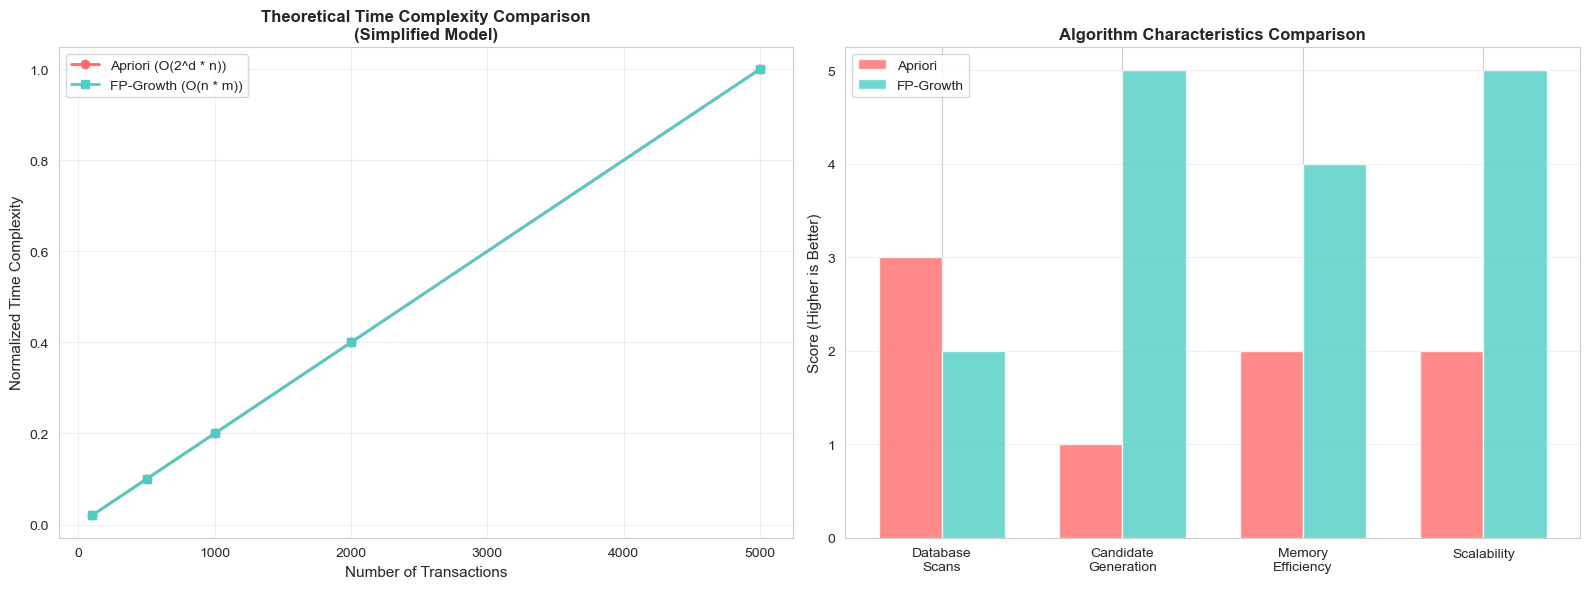

In [186]:
# Visualize algorithm complexity comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Theoretical complexity comparison
dataset_sizes = [100, 500, 1000, 2000, 5000]
apriori_complexity = [2**d * n for n in dataset_sizes for d in [3]]  # Simplified
fp_complexity = [n * 20 for n in dataset_sizes]  # Simplified (assuming ~20 items)

# Normalize for visualization
apriori_norm = [x / max(apriori_complexity) for x in apriori_complexity]
fp_norm = [x / max(fp_complexity) for x in fp_complexity]

axes[0].plot(dataset_sizes, apriori_norm, marker='o', linewidth=2, 
             label='Apriori (O(2^d * n))', color='#FF6B6B')
axes[0].plot(dataset_sizes, fp_norm, marker='s', linewidth=2, 
             label='FP-Growth (O(n * m))', color='#4ECDC4')
axes[0].set_xlabel('Number of Transactions', fontsize=11)
axes[0].set_ylabel('Normalized Time Complexity', fontsize=11)
axes[0].set_title('Theoretical Time Complexity Comparison\n(Simplified Model)', 
                  fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Algorithm approach comparison
approaches = ['Database\nScans', 'Candidate\nGeneration', 'Memory\nEfficiency', 'Scalability']
apriori_scores = [3, 1, 2, 2]  # Lower is better for some, but showing relative
fp_scores = [2, 5, 4, 5]  # Higher is better

x = np.arange(len(approaches))
width = 0.35

bars1 = axes[1].bar(x - width/2, apriori_scores, width, label='Apriori', 
                   color='#FF6B6B', alpha=0.8)
bars2 = axes[1].bar(x + width/2, fp_scores, width, label='FP-Growth', 
                   color='#4ECDC4', alpha=0.8)

axes[1].set_ylabel('Score (Higher is Better)', fontsize=11)
axes[1].set_title('Algorithm Characteristics Comparison', fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(approaches)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


### Challenges Faced and Solutions

One challenge encountered was that the IMDB Top 1000 dataset is not naturally transactional. The dataset contains movie information along with genres, but it is not in a format suitable for association rule mining. To address this, each movie was treated as a transaction and its genres were treated as items. Comma-separated genre strings were split into lists to create item sets. For example, this transformation was done in code using df['Genre_List'] = df['Genre'].str.split(', ').

Another challenge was the absence of the mlxtend library in the environment, which caused import errors. The solution was to install the library using pip with the command pip install mlxtend. This library provides efficient implementations of the Apriori and FP-Growth algorithms, making it essential for generating frequent itemsets and association rules.

A further challenge involved choosing an appropriate support threshold. Setting the threshold too high could miss important patterns, while setting it too low would generate too many itemsets and increase computational effort. To solve this, the dataset characteristics, 1000 transactions and 21 unique genres, were analyzed, and different thresholds were tested. A minimum support of 0.05 (5%) was chosen as a balance between finding meaningful patterns and maintaining computational efficiency, corresponding to at least 50 transactions.
